In [ ]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from matplotlib.pyplot import figure
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

from linear_regression_tf import LinearRegressionTF
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import tensorflow as tf
from keras.layers import Input, Embedding, Dense
from keras.models import Model
from sklearn.feature_extraction.text import CountVectorizer
from keras.layers import concatenate, Flatten
from sklearn.preprocessing import LabelEncoder
from keras.wrappers.scikit_learn import KerasRegressor

from keras.optimizers import Adam, SGD
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.manifold import TSNE
from keras import backend as K

# Conversion functions for various columns

In [ ]:
def parse_commision(commision):
    if commision.strip() == '':
        return float('nan')
    try:
        return re.match(r'\D*(\d+)\D*', commision).group(1)
    except:
        return float('nan')

In [ ]:
def parse_number(value):
    try:
        return float(value)
    except:
        return float('NaN')

In [ ]:
def parse_surface(char):
    char = char.replace('.', '')
    char = char.replace(',', '.')
    if 'mp' in char:
        try:
            return float(re.match(r'\D*(\d+\.?\d+)\s*mp.*', char).group(1))
        except:
            pass
    return float('NaN')

In [ ]:
def parse_year(char):
    try:
        return int(re.match(r'\D*(\d+)\D*', char).group(1))
    except:
        return float('nan')

In [ ]:
def parse_floor(char):
    if 'parter' in char.lower():
        floor = 0
    elif 'etaj' in char.lower():
        try:
            return int(re.match(r'.*etaj\s*(\d+)', char.lower()).group(1))
        except:
            return float('nan')

In [ ]:
def map_compartimentalization(comp):
    try:
        return {
        'decomandat': 0,
        'semidecomandat': 1,
        'nedecomandat': 2,
        'circular': 3,
        'vagon': 4
        }[comp]
    except:
        return 5

In [ ]:
def map_comfort(comf):
    if comf == 'lux':
        return 4
    return float(comf)

In [ ]:
def map_balconies(balc):
    if type(balc) is float:
        return balc
    if 'închise' not in balc:
        return float(balc)
    else:
        return -int(re.match(r'.*(\d+).*închise', balc).group(1))

In [ ]:
def map_structure(structure):
    try:
        return {
            'caramida': 1,
            'altele': 0,
            'metal': 2,
            'bca': 3,
            'beton': 4,
            'lemn': 5
        }[structure]
    except Exception as e:
        return float('nan')

In [11]:
def map_type(t):
    if t == 'bloc de apartamente':
        return 1
    elif t == 'casa/vila':
        return 2
    else:
        return 0

In [12]:
def parse_price(price):
    price = price.replace('.', '')
    price = price.replace(',', '')
    try:
        return float(price)
    except:
        return float('nan')

In [13]:
def parse_dist_underground(dist_underground):
    try:
        return int(re.match(r'.*\((\d+).*minut', dist_underground).group(1))
    except:
        return float('nan')

# Constructing the DataFrame

In [14]:
data = []
with open('dataset.txt', 'rt') as fin:
    for line in fin:
        d = json.loads(line)
        if 'An construcţie:' in d:
            d['An construcţie:'] = parse_year(d['An construcţie:'])
        if 'Etaj:' in d:
            d['Etaj:'] = parse_floor(d['Etaj:'])
        if 'Suprafaţă construită:' in d:
            d['Suprafaţă construită:'] = parse_surface(d['Suprafaţă construită:'])
        if 'Suprafaţă utilă totală:' in d:
            d['Suprafaţă utilă totală:'] = parse_surface(d['Suprafaţă utilă totală:'])
        if 'Suprafaţă utilă:' in d:
            d['Suprafaţă utilă:'] = parse_surface(d['Suprafaţă utilă:'])
        del d['currency']
        data.append(d)

In [15]:
df = pd.DataFrame.from_records(data)
df

An construcţie: Compartimentare: Confort:  Etaj:  Nr. balcoane:  \
0              2017.0       decomandat      lux    4.0            NaN   
1              2019.0       decomandat      lux    2.0              2   
2              2019.0       decomandat      lux    NaN              2   
3              2019.0   semidecomandat        1    1.0              1   
4              2019.0       decomandat        1    1.0              1   
5              2018.0       decomandat      lux    2.0              1   
6              2019.0       decomandat      lux    4.0            NaN   
7              2019.0     nedecomandat      lux    1.0              1   
8              2019.0       decomandat      lux    1.0              1   
9              2018.0   semidecomandat      lux    2.0              1   
10             2016.0       decomandat      lux   12.0              1   
11             2017.0       decomandat        1   13.0              1   
12             2007.0       decomandat        1    4.0              1   
13             1977.0       decomandat      lux    4.0            NaN   
14             2018.0       decomandat      lux    2.0            NaN   
15             1977.0       decomandat        1    7.0            NaN   
16             1941.0   semidecomandat        1    NaN            NaN   
17                NaN   semidecomandat      NaN    1.0  2 (1 închise)   
18             1941.0   semidecomandat      lux    2.0            NaN   
19             2018.0       decomandat      lux    2.0            NaN   
20             2008.0       decomandat      lux    1.0            NaN   
21             1941.0       decomandat      lux    3.0  2 (1 închise)   
22             2019.0       decomandat      lux    NaN            NaN   
23             2019.0       decomandat      lux    1.0              1   
24             2000.0       decomandat      lux    1.0            NaN   
25             2019.0       decomandat      lux    1.0              1   
26             2019.0       decomandat        1    1.0              2   
27             2018.0       decomandat        1    4.0            NaN   
28             2018.0       decomandat        1    2.0            NaN   
29             2011.0       decomandat      lux    2.0              1   
...               ...              ...      ...    ...            ...   
3969           2018.0       decomandat      lux    2.0              1   
3970           2018.0       decomandat        1    3.0              1   
3971           2016.0       decomandat      lux    9.0              2   
3972           2010.0   semidecomandat        1    6.0              1   
3973           2008.0       decomandat        1    4.0              1   
3974           2018.0       decomandat        1    1.0            NaN   
3975           2018.0       decomandat        1    7.0    1 (închise)   
3976           2016.0       decomandat        1    3.0              1   
3977           2019.0   semidecomandat      lux    3.0              2   
3978           2018.0       decomandat        1    2.0              2   
3979           2008.0       decomandat      lux    3.0            NaN   
3980           1986.0       decomandat        1    1.0              2   
3981           2019.0       decomandat        1    3.0              1   
3982           2018.0       decomandat        1    3.0              1   
3983           2019.0       decomandat      lux    1.0              1   
3984           1990.0   semidecomandat        1    8.0    1 (închise)   
3985              NaN              NaN        1    1.0              1   
3986           2017.0       decomandat      lux    4.0              1   
3987           2010.0   semidecomandat      lux    1.0              1   
3988           2017.0   semidecomandat      lux    6.0              1   
3989           2018.0       decomandat        1    NaN              1   
3990           2017.0       decomandat        1    1.0              1   
3991           1981.0       decomandat        1    2.0          

In [16]:
# Remove features used in later experiments
df['description'] = df['description'] + ' ' + df['specifications']
# del df['description']
# del df['location']
del df['poi']
del df['details']
# del df['dist_underground']
del df['specifications']

In [17]:
df.columns

Index(['An construcţie:', 'Compartimentare:', 'Confort:', 'Etaj:',
       'Nr. balcoane:', 'Nr. bucătării:', 'Nr. băi:', 'Nr. camere:',
       'Nr. garaje:', 'Nr. locuri parcare:', 'Regim înălţime:',
       'Structură rezistenţă:', 'Suprafaţă construită:',
       'Suprafaţă utilă totală:', 'Suprafaţă utilă:', 'Tip imobil:',
       'commission', 'description', 'dist_underground', 'location', 'price'],
      dtype='object')

In [18]:
df.columns = [
    'year', 'compartimentalization', 'comfort', 'floor', 'balconies', 'kitchens',
    'bathrooms', 'rooms', 'garages', 'parking spots', 'height regime',
    'structure', 'built surface', 'total useful surface', 'useful surface',
    'type', 'commission', 'description', 'dist_underground', 'location', 'price'
]

# Data Exploration & Cleaning

### Build Year

In [19]:
df['year'].describe()

count    3944.000000
mean     2005.402637
std        21.766710
min      1900.000000
25%      2000.000000
50%      2018.000000
75%      2018.000000
max      2023.000000
Name: year, dtype: float64

In [20]:
df['year'] = df['year'].fillna(int(df['year'].mean()))

### Compartimentalization style

In [21]:
df['compartimentalization'].value_counts()

decomandat        3000
semidecomandat     864
circular            32
nedecomandat        18
vagon                2
Name: compartimentalization, dtype: int64

In [22]:
df['compartimentalization'] = df['compartimentalization'].apply(map_compartimentalization)
df['compartimentalization'].value_counts()

0    3000
1     864
5      83
3      32
2      18
4       2
Name: compartimentalization, dtype: int64

### Comfort level

In [23]:
df['comfort'].value_counts()

1      2831
lux    1033
2        24
3        13
Name: comfort, dtype: int64

In [24]:
df['comfort'] = df['comfort'].apply(map_comfort)
df['comfort'] = df['comfort'].fillna(int(df['comfort'].mean()))
df['comfort'].value_counts()

1.0    2929
4.0    1033
2.0      24
3.0      13
Name: comfort, dtype: int64

### Apartment floor

In [25]:
df['floor'].value_counts()

1.0     960
2.0     747
3.0     490
4.0     356
5.0     285
6.0     169
7.0     134
8.0     132
9.0      86
10.0     57
11.0     35
13.0     13
12.0      7
14.0      4
15.0      4
25.0      1
20.0      1
17.0      1
Name: floor, dtype: int64

In [26]:
df['floor'] = df['floor'].fillna(df['floor'].median())

### Number of balconies

In [27]:
df['balconies'].value_counts()

1                2292
2                 397
1 (închise)       261
3                  62
2 (închise)        50
2 (1 închise)      26
3 (închise)         8
4                   7
5                   3
3 (1 închise)       2
4 (2 închise)       1
2 (4 închise)       1
1 (3 închise)       1
5 (2 închise)       1
1 (2 închise)       1
4 (1 închise)       1
12                  1
6                   1
Name: balconies, dtype: int64

In [28]:
df['balconies'] = df['balconies'].apply(map_balconies)
df['balconies'] = df['balconies'].fillna(df['balconies'].median())
df['balconies'].value_counts()

 1.0     3175
 2.0      397
-1.0      290
 3.0       62
-2.0       53
-3.0        9
 4.0        7
 5.0        3
-4.0        1
 12.0       1
 6.0        1
Name: balconies, dtype: int64

### Kitchens

In [29]:
df['kitchens'].value_counts()

1    3614
2      19
Name: kitchens, dtype: int64

In [30]:
df['kitchens'] = df['kitchens'].fillna(1)

### Bathrooms

In [31]:
df['bathrooms'].value_counts()

1     2275
2     1415
3      175
4       42
5        7
13       1
11       1
Name: bathrooms, dtype: int64

In [32]:
df['bathrooms'] = df['bathrooms'].fillna(1)

### Rooms

In [33]:
df['rooms'].value_counts()

2     1645
3     1418
1      453
4      386
5       77
6       11
7        5
34       1
33       1
12       1
17       1
Name: rooms, dtype: int64

In [34]:
df['rooms'] = df['rooms'].fillna(2)

### Garages

In [35]:
df['garages'] = df['garages'].fillna(0)

In [36]:
df['garages'].value_counts()

0     3749
1      226
2       18
3        4
30       1
34       1
Name: garages, dtype: int64

### Parking spots

In [37]:
df['parking spots'].value_counts()

1     844
2     107
3      12
56      7
4       4
28      4
37      4
40      2
34      1
99      1
38      1
7       1
50      1
Name: parking spots, dtype: int64

In [38]:
df['parking spots'] = df['parking spots'].fillna(0)

### Structure

In [39]:
df['structure'].value_counts()

beton       3105
caramida     190
altele       132
lemn           1
metal          1
Name: structure, dtype: int64

In [40]:
df['structure'] = df['structure'].fillna('beton')
df['structure'] = df['structure'].apply(map_structure)
df['structure'].value_counts()

4    3675
1     190
0     132
5       1
2       1
Name: structure, dtype: int64

### Height regime

In [41]:
df['height regime'].value_counts()

P+4E          431
P+5E          378
P+3E          322
P+8E          297
P+10E         279
P+6E          207
D+P+5E        140
P+11E         112
P+7E          110
S+P+3E        108
S+P+5E        107
S+P+11E        98
P+9E           98
S+P+4E         86
S+P+8E         86
S+P+10E        83
P+2E           81
S+P+6E         62
S+P+9E         59
S+P+7E         55
D+P+3E         46
D+P+4E         41
P+3E+M         40
D+P+6E         39
P+2E+M         35
D+P+2E+M       23
D+P+8E         23
S+P+16E        22
P+1E           22
D+P+2E         21
             ... 
S+P+17E         3
S+D+P+4E        3
S+D+P+3E        3
D+P+10E+M       3
D+P+1E          3
P+16E           2
D+P+6E+M        2
P+10E+M         2
S+D+P+13E       2
D+P+4E+M        2
S+P+1E          2
S+D+P+16E       2
P+7E+M          2
P+6E+M          2
D+P+8E+M        2
S+P+9E+M        2
P+9E+M          1
P+26E           1
P+20E           1
D+P+15E+M       1
S+D+P+2E+M      1
S+D+P+9E+M      1
S+P+20E         1
S+P+7E+M        1
S+P+15E   

In [42]:
del df['height regime']

### Surface measurements

In [43]:
df['built surface'] = df['built surface'].fillna(df['built surface'].mean())
df['total useful surface'] = df['total useful surface'].fillna(df['total useful surface'].mean())
df['useful surface'] = df['useful surface'].fillna(df['useful surface'].mean())

### Type

In [44]:
df['type'].value_counts()

bloc de apartamente    3904
casa/vila                81
Name: type, dtype: int64

In [45]:
df['type'] = df['type'].apply(map_type)

### Commission

In [46]:
df['commission'].value_counts()

 Comision 0%     2555
                 1444
Name: commission, dtype: int64

In [47]:
del df['commission']

### Price

In [48]:
df['price'][:5]

0    300.000
1    100.999
2    102.999
3     83.200
4     64.072
Name: price, dtype: object

In [49]:
df['price'] = df['price'].apply(parse_price)

### Distance to underground

In [50]:
df['dist_underground'] = df['dist_underground'].apply(parse_dist_underground)
df['dist_underground'].describe()

count    2659.000000
mean        9.832644
std         5.967889
min         1.000000
25%         5.000000
50%         9.000000
75%        14.000000
max        25.000000
Name: dist_underground, dtype: float64

In [51]:
df['dist_underground'] = df['dist_underground'].fillna(int(np.mean(df['dist_underground'])))

### Check for any other NaNs 

In [52]:
for col in df.columns:
    print(col, 'has nans:', df[col].isnull().any())
    if col not in ['description', 'location']:
        df[col] = pd.to_numeric(df[col])

year has nans: False
compartimentalization has nans: False
comfort has nans: False
floor has nans: False
balconies has nans: False
kitchens has nans: False
bathrooms has nans: False
rooms has nans: False
garages has nans: False
parking spots has nans: False
structure has nans: False
built surface has nans: False
total useful surface has nans: False
useful surface has nans: False
type has nans: False
description has nans: False
dist_underground has nans: False
location has nans: False
price has nans: True


In [53]:
print('Number of items without pricing:', sum(df['price'].isnull()))

Number of items without pricing: 11


In [115]:
# Since we can't predict anything without the price, we drop any nan rows
df = df.dropna()
df = df.reset_index()

# Analyze price distributions

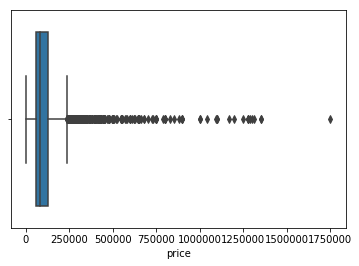

In [55]:
sns.boxplot(x=df['price'])

In [56]:
# Remove price outliers by the Tukey rule
Q3 = np.percentile(df['price'], 75)
Q1 = np.percentile(df['price'], 25)
IQR = Q3 - Q1

outliers = df['price'].loc[(df['price'] < (Q1 - 1.5 * IQR)) | (df['price'] > (Q3 + 1.5 * IQR))].index
df = df.drop(outliers)
print(f'There are now {len(df)} samples.')

There are now 3656 samples.


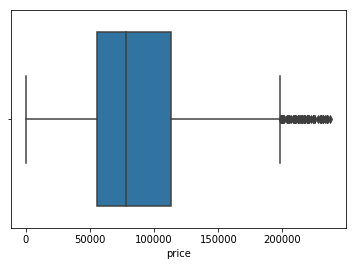

In [57]:
sns.boxplot(df['price'])

In [58]:
df['price'].describe()

count      3656.000000
mean      89106.234136
std       44928.005283
min           1.000000
25%       55582.250000
50%       77881.000000
75%      112910.750000
max      237350.000000
Name: price, dtype: float64

### Description text mining

In [59]:
print('Number of samples without description:', len(list(filter(lambda e: len(e) < 2, df['description']))))

Number of samples without description: 0


In [60]:
vectorizer = TfidfVectorizer(min_df=.2, max_df=0.8)

In [61]:
vectorizer.fit(df['description'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.8, max_features=None, min_df=0.2,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [62]:
len(vectorizer.vocabulary_)

108

In [63]:
vectorizer.vocabulary_

{'este': 36,
 'din': 32,
 'prin': 74,
 'care': 17,
 'se': 82,
 'face': 39,
 'zona': 107,
 'pe': 69,
 'foarte': 44,
 'acces': 1,
 'calitate': 14,
 'catv': 18,
 'telefon': 92,
 'centrala': 21,
 'proprie': 75,
 'climatizare': 22,
 'aer': 3,
 'conditionat': 26,
 'internet': 49,
 'cablu': 13,
 'fibra': 43,
 'optica': 65,
 'wireless': 106,
 'ferestre': 41,
 'geam': 45,
 'pvc': 77,
 'metal': 57,
 'izolatii': 51,
 'termice': 94,
 'exterior': 38,
 'usi': 99,
 'lemn': 53,
 'vopsea': 105,
 'lavabila': 52,
 'spatii': 85,
 'utile': 100,
 'terasa': 93,
 'contorizare': 29,
 'contor': 28,
 'apometre': 8,
 'mobilat': 61,
 'nemobilat': 63,
 'diverse': 34,
 'dotari': 35,
 'curte': 30,
 'lift': 54,
 'servicii': 83,
 'administrare': 2,
 'supraveghere': 91,
 'video': 104,
 'iluminat': 46,
 'stradal': 88,
 'mijloace': 59,
 'transport': 96,
 'comun': 25,
 'vecinătăţi': 103,
 'apartamente': 6,
 'parcare': 66,
 'apartamentul': 7,
 'camere': 16,
 'are': 9,
 'apartament': 5,
 'disponibilitate': 33,
 'proprietate'

## Feature correlations

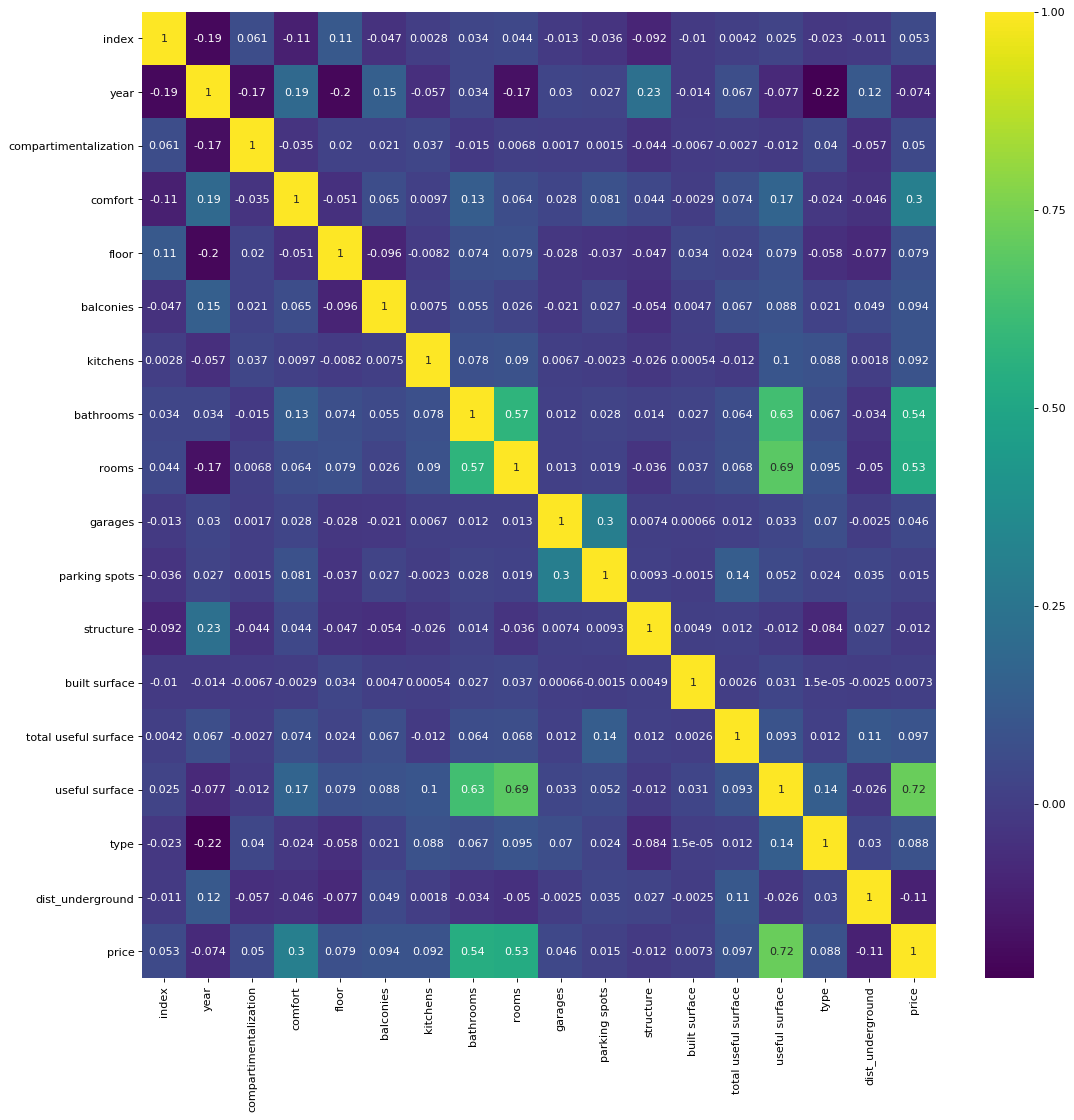

In [64]:
figure(num=None, figsize=(16, 16), dpi=80, facecolor='w', edgecolor='k')
sns.heatmap(df.corr(), cmap=plt.cm.viridis, annot=True)
plt.show()

# Model creation

In [160]:
def rmse(y_true, y_pred):
    y_true = y_true * std_y + mean_y
    y_pred = y_pred * std_y + mean_y
    return K.sqrt(K.mean(K.square(y_true - y_pred), axis=0))

In [161]:
# We select only variables linearly correlated with the price|
independent_variables = ['comfort', 'bathrooms', 'rooms', 'useful surface']

In [162]:
# Build and evaluate a model using 5-fold CV
X = np.array(df[independent_variables])
y = np.array(df['price'])
mean_y, std_y = np.mean(y), np.std(y)
y = (y - mean_y) / std_y

vectorizer = TfidfVectorizer(min_df=.2, max_df=0.8)
vectorizer.fit(df['description'])
text_data = vectorizer.transform(df['description'])

X = np.hstack([X, text_data.todense()])
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [163]:
locations = list(df['location'])

encoder = LabelEncoder()
encoder.fit(locations)
locations = encoder.transform(locations)

In [164]:
print('Vocabulary size:', len(encoder.classes_))
embedding_size = int(10 * np.ceil(328 ** (1/4)))
embedding_size

Vocabulary size: 346


50

In [165]:
from keras.layers import BatchNormalization, Dropout, ReLU

In [166]:
def schedule(epoch, lr):
    if epoch in [500, 1500]:
        return lr / 3.0
    return lr
scheduler = LearningRateScheduler(schedule=schedule)

In [167]:
# Inputs are the raw features and the location
mined_features = Input(shape=X.shape[1:], name='mined_features_input')
location = Input(shape=(1,), name='location_input')

# Embedding of location
embedded_location = Embedding(input_dim=len(encoder.classes_),
                              output_dim=embedding_size,
                              name='location_embedding')(location)
embedded_location = Flatten()(embedded_location)

# Run the raw features through a FC layer to get an intermediate representation
# latent_mined_features = Dropout(.2)(mined_features)
latent_mined_features = mined_features
latent_mined_features = Dense(64)(latent_mined_features)
latent_mined_features = BatchNormalization()(latent_mined_features)
latent_mined_features = ReLU()(latent_mined_features)

# Concatenate the inputs and perform a linear combination on a single neuron with linear activation
# this is, essentially, a linear regression
x = concatenate([latent_mined_features, embedded_location])
x = BatchNormalization()(x)  # normalize again to homogenize the features
# x = Dropout(.2)(x)
out = Dense(1, name='output', activation='linear')(x)
model = Model(inputs=[mined_features, location], outputs=out)
model.compile(optimizer=Adam(lr=0.01), loss='mean_squared_error', metrics=[rmse])

In [168]:
history = model.fit([X, locations], y, epochs=3000,
                    callbacks=[scheduler, EarlyStopping(patience=100, monitor='rmse'),
                               ModelCheckpoint('models/embedding.h5', monitor='rmse')],
                    batch_size=X.shape[0])  # since there are so few data points we can do batch gradient descent

Epoch 1/3000
3656/3656 [==============================] - 3s 745us/step - loss: 2.3588 - rmse: 68993.1406
Epoch 2/3000
3656/3656 [==============================] - 0s 8us/step - loss: 2.4287 - rmse: 70007.9141
Epoch 3/3000
3656/3656 [==============================] - 0s 8us/step - loss: 1.1931 - rmse: 49068.3984
Epoch 4/3000
3656/3656 [==============================] - 0s 9us/step - loss: 0.8800 - rmse: 42140.8828
Epoch 5/3000
3656/3656 [==============================] - 0s 9us/step - loss: 0.8923 - rmse: 42434.7812
Epoch 6/3000
3656/3656 [==============================] - 0s 9us/step - loss: 0.7582 - rmse: 39114.4141
Epoch 7/3000
3656/3656 [==============================] - 0s 15us/step - loss: 0.5803 - rmse: 34219.5586
Epoch 8/3000
3656/3656 [==============================] - 0s 10us/step - loss: 0.4747 - rmse: 30949.1562
Epoch 9/3000
3656/3656 [==============================] - 0s 10us/step - loss: 0.4308 - rmse: 29485.5625
Epoch 10/3000
3656/3656 [==============================] - 

Epoch 79/3000
3656/3656 [==============================] - 0s 9us/step - loss: 0.0750 - rmse: 12301.5088
Epoch 80/3000
3656/3656 [==============================] - 0s 10us/step - loss: 0.0741 - rmse: 12231.4258
Epoch 81/3000
3656/3656 [==============================] - 0s 11us/step - loss: 0.0733 - rmse: 12161.7666
Epoch 82/3000
3656/3656 [==============================] - 0s 9us/step - loss: 0.0725 - rmse: 12091.8916
Epoch 83/3000
3656/3656 [==============================] - 0s 10us/step - loss: 0.0716 - rmse: 12020.5361
Epoch 84/3000
3656/3656 [==============================] - 0s 10us/step - loss: 0.0707 - rmse: 11948.0479
Epoch 85/3000
3656/3656 [==============================] - 0s 15us/step - loss: 0.0699 - rmse: 11875.5996
Epoch 86/3000
3656/3656 [==============================] - 0s 8us/step - loss: 0.0690 - rmse: 11803.6006
Epoch 87/3000
3656/3656 [==============================] - 0s 8us/step - loss: 0.0682 - rmse: 11732.2090
Epoch 88/3000
3656/3656 [=========================

Epoch 157/3000
3656/3656 [==============================] - 0s 11us/step - loss: 0.0272 - rmse: 7402.1089
Epoch 158/3000
3656/3656 [==============================] - 0s 9us/step - loss: 0.0268 - rmse: 7352.9736
Epoch 159/3000
3656/3656 [==============================] - 0s 11us/step - loss: 0.0264 - rmse: 7301.8901
Epoch 160/3000
3656/3656 [==============================] - 0s 10us/step - loss: 0.0261 - rmse: 7253.0293
Epoch 161/3000
3656/3656 [==============================] - 0s 11us/step - loss: 0.0257 - rmse: 7204.8960
Epoch 162/3000
3656/3656 [==============================] - 0s 10us/step - loss: 0.0254 - rmse: 7157.0020
Epoch 163/3000
3656/3656 [==============================] - 0s 9us/step - loss: 0.0250 - rmse: 7109.6533
Epoch 164/3000
3656/3656 [==============================] - 0s 14us/step - loss: 0.0247 - rmse: 7062.5146
Epoch 165/3000
3656/3656 [==============================] - 0s 9us/step - loss: 0.0244 - rmse: 7016.6562
Epoch 166/3000
3656/3656 [=======================

Epoch 235/3000
3656/3656 [==============================] - 0s 10us/step - loss: 0.0107 - rmse: 4655.3340
Epoch 236/3000
3656/3656 [==============================] - 0s 11us/step - loss: 0.0107 - rmse: 4652.4917
Epoch 237/3000
3656/3656 [==============================] - 0s 11us/step - loss: 0.0107 - rmse: 4649.0625
Epoch 238/3000
3656/3656 [==============================] - 0s 10us/step - loss: 0.0107 - rmse: 4644.9424
Epoch 239/3000
3656/3656 [==============================] - 0s 9us/step - loss: 0.0106 - rmse: 4632.0000
Epoch 240/3000
3656/3656 [==============================] - 0s 9us/step - loss: 0.0105 - rmse: 4608.7124
Epoch 241/3000
3656/3656 [==============================] - 0s 9us/step - loss: 0.0103 - rmse: 4570.0181
Epoch 242/3000
3656/3656 [==============================] - 0s 11us/step - loss: 0.0101 - rmse: 4523.9028
Epoch 243/3000
3656/3656 [==============================] - 0s 11us/step - loss: 0.0099 - rmse: 4478.0029
Epoch 244/3000
3656/3656 [=======================

Epoch 313/3000
3656/3656 [==============================] - 0s 10us/step - loss: 0.0058 - rmse: 3410.9690
Epoch 314/3000
3656/3656 [==============================] - 0s 13us/step - loss: 0.0056 - rmse: 3350.4514
Epoch 315/3000
3656/3656 [==============================] - 0s 20us/step - loss: 0.0055 - rmse: 3336.1204
Epoch 316/3000
3656/3656 [==============================] - 0s 12us/step - loss: 0.0055 - rmse: 3337.6714
Epoch 317/3000
3656/3656 [==============================] - 0s 10us/step - loss: 0.0055 - rmse: 3332.7947
Epoch 318/3000
3656/3656 [==============================] - 0s 9us/step - loss: 0.0055 - rmse: 3329.2041
Epoch 319/3000
3656/3656 [==============================] - 0s 12us/step - loss: 0.0055 - rmse: 3346.1738
Epoch 320/3000
3656/3656 [==============================] - 0s 12us/step - loss: 0.0056 - rmse: 3376.1477
Epoch 321/3000
3656/3656 [==============================] - 0s 9us/step - loss: 0.0057 - rmse: 3403.8438
Epoch 322/3000
3656/3656 [======================

Epoch 391/3000
3656/3656 [==============================] - 0s 12us/step - loss: 0.0053 - rmse: 3279.9031
Epoch 392/3000
3656/3656 [==============================] - 0s 11us/step - loss: 0.0042 - rmse: 2924.3362
Epoch 393/3000
3656/3656 [==============================] - 0s 9us/step - loss: 0.0036 - rmse: 2690.5959
Epoch 394/3000
3656/3656 [==============================] - 0s 9us/step - loss: 0.0037 - rmse: 2717.4761
Epoch 395/3000
3656/3656 [==============================] - 0s 9us/step - loss: 0.0041 - rmse: 2867.3337
Epoch 396/3000
3656/3656 [==============================] - 0s 13us/step - loss: 0.0043 - rmse: 2938.0093
Epoch 397/3000
3656/3656 [==============================] - 0s 10us/step - loss: 0.0040 - rmse: 2856.9619
Epoch 398/3000
3656/3656 [==============================] - 0s 9us/step - loss: 0.0036 - rmse: 2708.8982
Epoch 399/3000
3656/3656 [==============================] - 0s 9us/step - loss: 0.0034 - rmse: 2610.3501
Epoch 400/3000
3656/3656 [=========================

Epoch 469/3000
3656/3656 [==============================] - 0s 11us/step - loss: 0.0020 - rmse: 2010.0350
Epoch 470/3000
3656/3656 [==============================] - 0s 9us/step - loss: 0.0021 - rmse: 2051.4287
Epoch 471/3000
3656/3656 [==============================] - 0s 10us/step - loss: 0.0022 - rmse: 2107.8225
Epoch 472/3000
3656/3656 [==============================] - 0s 11us/step - loss: 0.0023 - rmse: 2133.1177
Epoch 473/3000
3656/3656 [==============================] - 0s 9us/step - loss: 0.0022 - rmse: 2113.3025
Epoch 474/3000
3656/3656 [==============================] - 0s 9us/step - loss: 0.0021 - rmse: 2060.7095
Epoch 475/3000
3656/3656 [==============================] - 0s 13us/step - loss: 0.0020 - rmse: 2002.4275
Epoch 476/3000
3656/3656 [==============================] - 0s 10us/step - loss: 0.0019 - rmse: 1965.3839
Epoch 477/3000
3656/3656 [==============================] - 0s 10us/step - loss: 0.0019 - rmse: 1958.7834
Epoch 478/3000
3656/3656 [=======================

Epoch 547/3000
3656/3656 [==============================] - 0s 11us/step - loss: 0.0015 - rmse: 1750.8853
Epoch 548/3000
3656/3656 [==============================] - 0s 10us/step - loss: 0.0015 - rmse: 1744.9600
Epoch 549/3000
3656/3656 [==============================] - 0s 10us/step - loss: 0.0015 - rmse: 1745.7452
Epoch 550/3000
3656/3656 [==============================] - 0s 14us/step - loss: 0.0015 - rmse: 1743.3120
Epoch 551/3000
3656/3656 [==============================] - 0s 10us/step - loss: 0.0015 - rmse: 1740.5010
Epoch 552/3000
3656/3656 [==============================] - 0s 11us/step - loss: 0.0015 - rmse: 1740.9569
Epoch 553/3000
3656/3656 [==============================] - 0s 12us/step - loss: 0.0015 - rmse: 1736.6262
Epoch 554/3000
3656/3656 [==============================] - 0s 16us/step - loss: 0.0015 - rmse: 1737.1133
Epoch 555/3000
3656/3656 [==============================] - 0s 13us/step - loss: 0.0015 - rmse: 1734.0419
Epoch 556/3000
3656/3656 [====================

Epoch 625/3000
3656/3656 [==============================] - 0s 10us/step - loss: 0.0013 - rmse: 1629.0759
Epoch 626/3000
3656/3656 [==============================] - 0s 12us/step - loss: 0.0013 - rmse: 1627.6515
Epoch 627/3000
3656/3656 [==============================] - 0s 12us/step - loss: 0.0013 - rmse: 1626.2528
Epoch 628/3000
3656/3656 [==============================] - 0s 8us/step - loss: 0.0013 - rmse: 1624.8479
Epoch 629/3000
3656/3656 [==============================] - 0s 10us/step - loss: 0.0013 - rmse: 1623.4965
Epoch 630/3000
3656/3656 [==============================] - 0s 13us/step - loss: 0.0013 - rmse: 1622.0417
Epoch 631/3000
3656/3656 [==============================] - 0s 9us/step - loss: 0.0013 - rmse: 1620.6062
Epoch 632/3000
3656/3656 [==============================] - 0s 11us/step - loss: 0.0013 - rmse: 1619.2183
Epoch 633/3000
3656/3656 [==============================] - 0s 11us/step - loss: 0.0013 - rmse: 1617.8612
Epoch 634/3000
3656/3656 [======================

Epoch 703/3000
3656/3656 [==============================] - 0s 13us/step - loss: 0.0011 - rmse: 1522.8424
Epoch 704/3000
3656/3656 [==============================] - 0s 11us/step - loss: 0.0011 - rmse: 1521.6777
Epoch 705/3000
3656/3656 [==============================] - 0s 8us/step - loss: 0.0011 - rmse: 1520.3901
Epoch 706/3000
3656/3656 [==============================] - 0s 9us/step - loss: 0.0011 - rmse: 1519.0087
Epoch 707/3000
3656/3656 [==============================] - 0s 10us/step - loss: 0.0011 - rmse: 1517.7968
Epoch 708/3000
3656/3656 [==============================] - 0s 13us/step - loss: 0.0011 - rmse: 1516.5262
Epoch 709/3000
3656/3656 [==============================] - 0s 12us/step - loss: 0.0011 - rmse: 1515.2603
Epoch 710/3000
3656/3656 [==============================] - 0s 10us/step - loss: 0.0011 - rmse: 1514.0068
Epoch 711/3000
3656/3656 [==============================] - 0s 9us/step - loss: 0.0011 - rmse: 1512.7920
Epoch 712/3000
3656/3656 [=======================

Epoch 781/3000
3656/3656 [==============================] - 0s 15us/step - loss: 0.0010 - rmse: 1426.8311
Epoch 782/3000
3656/3656 [==============================] - 0s 9us/step - loss: 0.0010 - rmse: 1425.6124
Epoch 783/3000
3656/3656 [==============================] - 0s 8us/step - loss: 0.0010 - rmse: 1424.4331
Epoch 784/3000
3656/3656 [==============================] - 0s 9us/step - loss: 0.0010 - rmse: 1423.2362
Epoch 785/3000
3656/3656 [==============================] - 0s 11us/step - loss: 0.0010 - rmse: 1422.0490
Epoch 786/3000
3656/3656 [==============================] - 0s 11us/step - loss: 0.0010 - rmse: 1420.8447
Epoch 787/3000
3656/3656 [==============================] - 0s 12us/step - loss: 9.9875e-04 - rmse: 1419.6648
Epoch 788/3000
3656/3656 [==============================] - 0s 13us/step - loss: 9.9709e-04 - rmse: 1418.4867
Epoch 789/3000
3656/3656 [==============================] - 0s 10us/step - loss: 9.9550e-04 - rmse: 1417.3506
Epoch 790/3000
3656/3656 [===========

Epoch 856/3000
3656/3656 [==============================] - 0s 9us/step - loss: 8.9380e-04 - rmse: 1343.0087
Epoch 857/3000
3656/3656 [==============================] - 0s 11us/step - loss: 8.9240e-04 - rmse: 1341.9508
Epoch 858/3000
3656/3656 [==============================] - 0s 9us/step - loss: 8.9117e-04 - rmse: 1341.0284
Epoch 859/3000
3656/3656 [==============================] - 0s 11us/step - loss: 8.8968e-04 - rmse: 1339.9060
Epoch 860/3000
3656/3656 [==============================] - 0s 8us/step - loss: 8.8841e-04 - rmse: 1338.9473
Epoch 861/3000
3656/3656 [==============================] - 0s 11us/step - loss: 8.8707e-04 - rmse: 1337.9432
Epoch 862/3000
3656/3656 [==============================] - 0s 11us/step - loss: 8.8568e-04 - rmse: 1336.8923
Epoch 863/3000
3656/3656 [==============================] - 0s 14us/step - loss: 8.8437e-04 - rmse: 1335.9044
Epoch 864/3000
3656/3656 [==============================] - 0s 10us/step - loss: 8.8303e-04 - rmse: 1334.8906
Epoch 865/300

Epoch 931/3000
3656/3656 [==============================] - 0s 12us/step - loss: 7.9749e-04 - rmse: 1268.5908
Epoch 932/3000
3656/3656 [==============================] - 0s 13us/step - loss: 7.9638e-04 - rmse: 1267.7065
Epoch 933/3000
3656/3656 [==============================] - 0s 8us/step - loss: 7.9520e-04 - rmse: 1266.7661
Epoch 934/3000
3656/3656 [==============================] - 0s 10us/step - loss: 7.9406e-04 - rmse: 1265.8605
Epoch 935/3000
3656/3656 [==============================] - 0s 10us/step - loss: 7.9279e-04 - rmse: 1264.8400
Epoch 936/3000
3656/3656 [==============================] - 0s 11us/step - loss: 7.9161e-04 - rmse: 1263.9038
Epoch 937/3000
3656/3656 [==============================] - 0s 14us/step - loss: 7.9035e-04 - rmse: 1262.8962
Epoch 938/3000
3656/3656 [==============================] - 0s 9us/step - loss: 7.8928e-04 - rmse: 1262.0413
Epoch 939/3000
3656/3656 [==============================] - 0s 8us/step - loss: 7.8801e-04 - rmse: 1261.0240
Epoch 940/300

Epoch 1006/3000
3656/3656 [==============================] - 0s 8us/step - loss: 7.1385e-04 - rmse: 1200.2180
Epoch 1007/3000
3656/3656 [==============================] - 0s 9us/step - loss: 7.1284e-04 - rmse: 1199.3694
Epoch 1008/3000
3656/3656 [==============================] - 0s 11us/step - loss: 7.1182e-04 - rmse: 1198.5168
Epoch 1009/3000
3656/3656 [==============================] - 0s 11us/step - loss: 7.1072e-04 - rmse: 1197.5903
Epoch 1010/3000
3656/3656 [==============================] - 0s 11us/step - loss: 7.0975e-04 - rmse: 1196.7714
Epoch 1011/3000
3656/3656 [==============================] - 0s 13us/step - loss: 7.0869e-04 - rmse: 1195.8748
Epoch 1012/3000
3656/3656 [==============================] - 0s 8us/step - loss: 7.0770e-04 - rmse: 1195.0405
Epoch 1013/3000
3656/3656 [==============================] - 0s 11us/step - loss: 7.0657e-04 - rmse: 1194.0823
Epoch 1014/3000
3656/3656 [==============================] - 0s 9us/step - loss: 7.0560e-04 - rmse: 1193.2634
Epoch

Epoch 1081/3000
3656/3656 [==============================] - 0s 8us/step - loss: 6.3777e-04 - rmse: 1134.4596
Epoch 1082/3000
3656/3656 [==============================] - 0s 13us/step - loss: 6.3691e-04 - rmse: 1133.6979
Epoch 1083/3000
3656/3656 [==============================] - 0s 10us/step - loss: 6.3583e-04 - rmse: 1132.7317
Epoch 1084/3000
3656/3656 [==============================] - 0s 9us/step - loss: 6.3489e-04 - rmse: 1131.8943
Epoch 1085/3000
3656/3656 [==============================] - 0s 9us/step - loss: 6.3392e-04 - rmse: 1131.0338
Epoch 1086/3000
3656/3656 [==============================] - 0s 9us/step - loss: 6.3295e-04 - rmse: 1130.1626
Epoch 1087/3000
3656/3656 [==============================] - 0s 11us/step - loss: 6.3196e-04 - rmse: 1129.2798
Epoch 1088/3000
3656/3656 [==============================] - 0s 10us/step - loss: 6.3097e-04 - rmse: 1128.3961
Epoch 1089/3000
3656/3656 [==============================] - 0s 21us/step - loss: 6.2992e-04 - rmse: 1127.4562
Epoch

Epoch 1155/3000
3656/3656 [==============================] - 0s 10us/step - loss: 5.7156e-04 - rmse: 1073.9614
Epoch 1156/3000
3656/3656 [==============================] - 0s 10us/step - loss: 5.7075e-04 - rmse: 1073.1980
Epoch 1157/3000
3656/3656 [==============================] - 0s 10us/step - loss: 5.6990e-04 - rmse: 1072.4037
Epoch 1158/3000
3656/3656 [==============================] - 0s 13us/step - loss: 5.6907e-04 - rmse: 1071.6237
Epoch 1159/3000
3656/3656 [==============================] - 0s 10us/step - loss: 5.6830e-04 - rmse: 1070.8927
Epoch 1160/3000
3656/3656 [==============================] - 0s 12us/step - loss: 5.6752e-04 - rmse: 1070.1611
Epoch 1161/3000
3656/3656 [==============================] - 0s 10us/step - loss: 5.6670e-04 - rmse: 1069.3895
Epoch 1162/3000
3656/3656 [==============================] - 0s 12us/step - loss: 5.6592e-04 - rmse: 1068.6514
Epoch 1163/3000
3656/3656 [==============================] - 0s 13us/step - loss: 5.6519e-04 - rmse: 1067.9592
E

Epoch 1229/3000
3656/3656 [==============================] - 0s 13us/step - loss: 5.1549e-04 - rmse: 1019.9225
Epoch 1230/3000
3656/3656 [==============================] - 0s 9us/step - loss: 5.1478e-04 - rmse: 1019.2227
Epoch 1231/3000
3656/3656 [==============================] - 0s 10us/step - loss: 5.1405e-04 - rmse: 1018.5024
Epoch 1232/3000
3656/3656 [==============================] - 0s 9us/step - loss: 5.1340e-04 - rmse: 1017.8584
Epoch 1233/3000
3656/3656 [==============================] - 0s 37us/step - loss: 5.1272e-04 - rmse: 1017.1818
Epoch 1234/3000
3656/3656 [==============================] - 0s 12us/step - loss: 5.1198e-04 - rmse: 1016.4450
Epoch 1235/3000
3656/3656 [==============================] - 0s 9us/step - loss: 5.1134e-04 - rmse: 1015.8120
Epoch 1236/3000
3656/3656 [==============================] - 0s 11us/step - loss: 5.1061e-04 - rmse: 1015.0822
Epoch 1237/3000
3656/3656 [==============================] - 0s 9us/step - loss: 5.0990e-04 - rmse: 1014.3833
Epoch

Epoch 1304/3000
3656/3656 [==============================] - 0s 9us/step - loss: 4.6696e-04 - rmse: 970.7304
Epoch 1305/3000
3656/3656 [==============================] - 0s 9us/step - loss: 4.6640e-04 - rmse: 970.1442
Epoch 1306/3000
3656/3656 [==============================] - 0s 15us/step - loss: 4.6586e-04 - rmse: 969.5816
Epoch 1307/3000
3656/3656 [==============================] - 0s 17us/step - loss: 4.6526e-04 - rmse: 968.9587
Epoch 1308/3000
3656/3656 [==============================] - 0s 20us/step - loss: 4.6463e-04 - rmse: 968.3051
Epoch 1309/3000
3656/3656 [==============================] - 0s 11us/step - loss: 4.6408e-04 - rmse: 967.7327
Epoch 1310/3000
3656/3656 [==============================] - 0s 12us/step - loss: 4.6352e-04 - rmse: 967.1437
Epoch 1311/3000
3656/3656 [==============================] - 0s 9us/step - loss: 4.6292e-04 - rmse: 966.5239
Epoch 1312/3000
3656/3656 [==============================] - 0s 14us/step - loss: 4.6232e-04 - rmse: 965.8914
Epoch 1313/30

Epoch 1379/3000
3656/3656 [==============================] - 0s 8us/step - loss: 4.2665e-04 - rmse: 927.8854
Epoch 1380/3000
3656/3656 [==============================] - 0s 9us/step - loss: 4.2620e-04 - rmse: 927.3934
Epoch 1381/3000
3656/3656 [==============================] - 0s 12us/step - loss: 4.2568e-04 - rmse: 926.8250
Epoch 1382/3000
3656/3656 [==============================] - 0s 12us/step - loss: 4.2516e-04 - rmse: 926.2668
Epoch 1383/3000
3656/3656 [==============================] - 0s 10us/step - loss: 4.2471e-04 - rmse: 925.7708
Epoch 1384/3000
3656/3656 [==============================] - 0s 9us/step - loss: 4.2420e-04 - rmse: 925.2157
Epoch 1385/3000
3656/3656 [==============================] - 0s 11us/step - loss: 4.2374e-04 - rmse: 924.7169
Epoch 1386/3000
3656/3656 [==============================] - 0s 10us/step - loss: 4.2336e-04 - rmse: 924.3017
Epoch 1387/3000
3656/3656 [==============================] - 0s 10us/step - loss: 4.2284e-04 - rmse: 923.7262
Epoch 1388/30

Epoch 1454/3000
3656/3656 [==============================] - 0s 9us/step - loss: 3.9244e-04 - rmse: 889.9056
Epoch 1455/3000
3656/3656 [==============================] - 0s 11us/step - loss: 3.9217e-04 - rmse: 889.5992
Epoch 1456/3000
3656/3656 [==============================] - 0s 12us/step - loss: 3.9200e-04 - rmse: 889.4104
Epoch 1457/3000
3656/3656 [==============================] - 0s 9us/step - loss: 3.9193e-04 - rmse: 889.3237
Epoch 1458/3000
3656/3656 [==============================] - 0s 13us/step - loss: 3.9201e-04 - rmse: 889.4211
Epoch 1459/3000
3656/3656 [==============================] - 0s 11us/step - loss: 3.9231e-04 - rmse: 889.7576
Epoch 1460/3000
3656/3656 [==============================] - 0s 12us/step - loss: 3.9265e-04 - rmse: 890.1492
Epoch 1461/3000
3656/3656 [==============================] - 0s 9us/step - loss: 3.9302e-04 - rmse: 890.5618
Epoch 1462/3000
3656/3656 [==============================] - 0s 13us/step - loss: 3.9336e-04 - rmse: 890.9459
Epoch 1463/30

Epoch 1529/3000
3656/3656 [==============================] - 0s 11us/step - loss: 3.7278e-04 - rmse: 867.3265
Epoch 1530/3000
3656/3656 [==============================] - 0s 13us/step - loss: 3.6980e-04 - rmse: 863.8582
Epoch 1531/3000
3656/3656 [==============================] - 0s 11us/step - loss: 3.7145e-04 - rmse: 865.7819
Epoch 1532/3000
3656/3656 [==============================] - 0s 8us/step - loss: 3.7054e-04 - rmse: 864.7227
Epoch 1533/3000
3656/3656 [==============================] - 0s 10us/step - loss: 3.6973e-04 - rmse: 863.7689
Epoch 1534/3000
3656/3656 [==============================] - 0s 9us/step - loss: 3.7083e-04 - rmse: 865.0552
Epoch 1535/3000
3656/3656 [==============================] - 0s 13us/step - loss: 3.6910e-04 - rmse: 863.0374
Epoch 1536/3000
3656/3656 [==============================] - 0s 11us/step - loss: 3.7005e-04 - rmse: 864.1466
Epoch 1537/3000
3656/3656 [==============================] - 0s 9us/step - loss: 3.6933e-04 - rmse: 863.3077
Epoch 1538/30

Epoch 1604/3000
3656/3656 [==============================] - 0s 8us/step - loss: 3.6022e-04 - rmse: 852.5945
Epoch 1605/3000
3656/3656 [==============================] - 0s 8us/step - loss: 3.6010e-04 - rmse: 852.4534
Epoch 1606/3000
3656/3656 [==============================] - 0s 14us/step - loss: 3.5997e-04 - rmse: 852.2958
Epoch 1607/3000
3656/3656 [==============================] - 0s 11us/step - loss: 3.5983e-04 - rmse: 852.1321
Epoch 1608/3000
3656/3656 [==============================] - 0s 10us/step - loss: 3.5970e-04 - rmse: 851.9830
Epoch 1609/3000
3656/3656 [==============================] - 0s 9us/step - loss: 3.5957e-04 - rmse: 851.8283
Epoch 1610/3000
3656/3656 [==============================] - 0s 9us/step - loss: 3.5945e-04 - rmse: 851.6858
Epoch 1611/3000
3656/3656 [==============================] - 0s 10us/step - loss: 3.5932e-04 - rmse: 851.5296
Epoch 1612/3000
3656/3656 [==============================] - 0s 13us/step - loss: 3.5919e-04 - rmse: 851.3746
Epoch 1613/300

Epoch 1679/3000
3656/3656 [==============================] - 0s 10us/step - loss: 3.5063e-04 - rmse: 841.1725
Epoch 1680/3000
3656/3656 [==============================] - 0s 11us/step - loss: 3.5054e-04 - rmse: 841.0563
Epoch 1681/3000
3656/3656 [==============================] - 0s 10us/step - loss: 3.5040e-04 - rmse: 840.8958
Epoch 1682/3000
3656/3656 [==============================] - 0s 10us/step - loss: 3.5029e-04 - rmse: 840.7594
Epoch 1683/3000
3656/3656 [==============================] - 0s 10us/step - loss: 3.5016e-04 - rmse: 840.5989
Epoch 1684/3000
3656/3656 [==============================] - 0s 13us/step - loss: 3.5003e-04 - rmse: 840.4530
Epoch 1685/3000
3656/3656 [==============================] - 0s 8us/step - loss: 3.4991e-04 - rmse: 840.3049
Epoch 1686/3000
3656/3656 [==============================] - 0s 11us/step - loss: 3.4979e-04 - rmse: 840.1546
Epoch 1687/3000
3656/3656 [==============================] - 0s 10us/step - loss: 3.4965e-04 - rmse: 839.9954
Epoch 1688/

Epoch 1754/3000
3656/3656 [==============================] - 0s 17us/step - loss: 3.4150e-04 - rmse: 830.1475
Epoch 1755/3000
3656/3656 [==============================] - 0s 14us/step - loss: 3.4138e-04 - rmse: 830.0021
Epoch 1756/3000
3656/3656 [==============================] - 0s 9us/step - loss: 3.4125e-04 - rmse: 829.8450
Epoch 1757/3000
3656/3656 [==============================] - 0s 8us/step - loss: 3.4113e-04 - rmse: 829.6984
Epoch 1758/3000
3656/3656 [==============================] - 0s 9us/step - loss: 3.4101e-04 - rmse: 829.5482
Epoch 1759/3000
3656/3656 [==============================] - 0s 9us/step - loss: 3.4089e-04 - rmse: 829.4065
Epoch 1760/3000
3656/3656 [==============================] - 0s 11us/step - loss: 3.4078e-04 - rmse: 829.2655
Epoch 1761/3000
3656/3656 [==============================] - 0s 9us/step - loss: 3.4066e-04 - rmse: 829.1261
Epoch 1762/3000
3656/3656 [==============================] - 0s 10us/step - loss: 3.4055e-04 - rmse: 828.9933
Epoch 1763/3000

Epoch 1829/3000
3656/3656 [==============================] - 0s 12us/step - loss: 3.3252e-04 - rmse: 819.1542
Epoch 1830/3000
3656/3656 [==============================] - 0s 9us/step - loss: 3.3240e-04 - rmse: 819.0027
Epoch 1831/3000
3656/3656 [==============================] - 0s 15us/step - loss: 3.3227e-04 - rmse: 818.8541
Epoch 1832/3000
3656/3656 [==============================] - 0s 9us/step - loss: 3.3215e-04 - rmse: 818.6962
Epoch 1833/3000
3656/3656 [==============================] - 0s 9us/step - loss: 3.3204e-04 - rmse: 818.5593
Epoch 1834/3000
3656/3656 [==============================] - 0s 13us/step - loss: 3.3191e-04 - rmse: 818.4044
Epoch 1835/3000
3656/3656 [==============================] - 0s 8us/step - loss: 3.3179e-04 - rmse: 818.2575
Epoch 1836/3000
3656/3656 [==============================] - 0s 8us/step - loss: 3.3168e-04 - rmse: 818.1152
Epoch 1837/3000
3656/3656 [==============================] - 0s 11us/step - loss: 3.3155e-04 - rmse: 817.9612
Epoch 1838/3000

Epoch 1904/3000
3656/3656 [==============================] - 0s 9us/step - loss: 3.2337e-04 - rmse: 807.8057
Epoch 1905/3000
3656/3656 [==============================] - 0s 9us/step - loss: 3.2325e-04 - rmse: 807.6615
Epoch 1906/3000
3656/3656 [==============================] - 0s 9us/step - loss: 3.2314e-04 - rmse: 807.5184
Epoch 1907/3000
3656/3656 [==============================] - 0s 9us/step - loss: 3.2302e-04 - rmse: 807.3663
Epoch 1908/3000
3656/3656 [==============================] - 0s 13us/step - loss: 3.2289e-04 - rmse: 807.2119
Epoch 1909/3000
3656/3656 [==============================] - 0s 9us/step - loss: 3.2276e-04 - rmse: 807.0460
Epoch 1910/3000
3656/3656 [==============================] - 0s 14us/step - loss: 3.2264e-04 - rmse: 806.8915
Epoch 1911/3000
3656/3656 [==============================] - 0s 13us/step - loss: 3.2254e-04 - rmse: 806.7694
Epoch 1912/3000
3656/3656 [==============================] - 0s 19us/step - loss: 3.2238e-04 - rmse: 806.5745
Epoch 1913/3000

Epoch 1979/3000
3656/3656 [==============================] - 0s 12us/step - loss: 3.1466e-04 - rmse: 796.8532
Epoch 1980/3000
3656/3656 [==============================] - 0s 8us/step - loss: 3.1455e-04 - rmse: 796.7170
Epoch 1981/3000
3656/3656 [==============================] - 0s 9us/step - loss: 3.1443e-04 - rmse: 796.5633
Epoch 1982/3000
3656/3656 [==============================] - 0s 11us/step - loss: 3.1431e-04 - rmse: 796.4161
Epoch 1983/3000
3656/3656 [==============================] - 0s 10us/step - loss: 3.1421e-04 - rmse: 796.2822
Epoch 1984/3000
3656/3656 [==============================] - 0s 10us/step - loss: 3.1408e-04 - rmse: 796.1246
Epoch 1985/3000
3656/3656 [==============================] - 0s 10us/step - loss: 3.1400e-04 - rmse: 796.0169
Epoch 1986/3000
3656/3656 [==============================] - 0s 15us/step - loss: 3.1389e-04 - rmse: 795.8818
Epoch 1987/3000
3656/3656 [==============================] - 0s 10us/step - loss: 3.1377e-04 - rmse: 795.7260
Epoch 1988/3

Epoch 2054/3000
3656/3656 [==============================] - 0s 12us/step - loss: 3.0611e-04 - rmse: 785.9561
Epoch 2055/3000
3656/3656 [==============================] - 0s 9us/step - loss: 3.0601e-04 - rmse: 785.8190
Epoch 2056/3000
3656/3656 [==============================] - 0s 10us/step - loss: 3.0591e-04 - rmse: 785.6939
Epoch 2057/3000
3656/3656 [==============================] - 0s 11us/step - loss: 3.0578e-04 - rmse: 785.5314
Epoch 2058/3000
3656/3656 [==============================] - 0s 9us/step - loss: 3.0568e-04 - rmse: 785.3989
Epoch 2059/3000
3656/3656 [==============================] - 0s 10us/step - loss: 3.0557e-04 - rmse: 785.2547
Epoch 2060/3000
3656/3656 [==============================] - 0s 15us/step - loss: 3.0546e-04 - rmse: 785.1168
Epoch 2061/3000
3656/3656 [==============================] - 0s 9us/step - loss: 3.0535e-04 - rmse: 784.9765
Epoch 2062/3000
3656/3656 [==============================] - 0s 9us/step - loss: 3.0523e-04 - rmse: 784.8171
Epoch 2063/300

Epoch 2129/3000
3656/3656 [==============================] - 0s 12us/step - loss: 2.9784e-04 - rmse: 775.2668
Epoch 2130/3000
3656/3656 [==============================] - 0s 20us/step - loss: 2.9774e-04 - rmse: 775.1312
Epoch 2131/3000
3656/3656 [==============================] - 0s 11us/step - loss: 2.9764e-04 - rmse: 775.0016
Epoch 2132/3000
3656/3656 [==============================] - 0s 11us/step - loss: 2.9752e-04 - rmse: 774.8526
Epoch 2133/3000
3656/3656 [==============================] - 0s 17us/step - loss: 2.9741e-04 - rmse: 774.7068
Epoch 2134/3000
3656/3656 [==============================] - 0s 12us/step - loss: 2.9729e-04 - rmse: 774.5448
Epoch 2135/3000
3656/3656 [==============================] - 0s 12us/step - loss: 2.9718e-04 - rmse: 774.4016
Epoch 2136/3000
3656/3656 [==============================] - 0s 15us/step - loss: 2.9707e-04 - rmse: 774.2592
Epoch 2137/3000
3656/3656 [==============================] - 0s 12us/step - loss: 2.9696e-04 - rmse: 774.1112
Epoch 2138

Epoch 2204/3000
3656/3656 [==============================] - 0s 28us/step - loss: 2.8975e-04 - rmse: 764.6682
Epoch 2205/3000
3656/3656 [==============================] - 0s 24us/step - loss: 2.8965e-04 - rmse: 764.5297
Epoch 2206/3000
3656/3656 [==============================] - 0s 29us/step - loss: 2.8954e-04 - rmse: 764.3834
Epoch 2207/3000
3656/3656 [==============================] - 0s 22us/step - loss: 2.8942e-04 - rmse: 764.2327
Epoch 2208/3000
3656/3656 [==============================] - 0s 18us/step - loss: 2.8931e-04 - rmse: 764.0864
Epoch 2209/3000
3656/3656 [==============================] - 0s 34us/step - loss: 2.8920e-04 - rmse: 763.9338
Epoch 2210/3000
3656/3656 [==============================] - 0s 28us/step - loss: 2.8909e-04 - rmse: 763.7935
Epoch 2211/3000
3656/3656 [==============================] - 0s 23us/step - loss: 2.8898e-04 - rmse: 763.6457
Epoch 2212/3000
3656/3656 [==============================] - 0s 17us/step - loss: 2.8888e-04 - rmse: 763.5128
Epoch 2213

Epoch 2279/3000
3656/3656 [==============================] - 0s 18us/step - loss: 2.8173e-04 - rmse: 754.0054
Epoch 2280/3000
3656/3656 [==============================] - 0s 25us/step - loss: 2.8162e-04 - rmse: 753.8537
Epoch 2281/3000
3656/3656 [==============================] - 0s 25us/step - loss: 2.8150e-04 - rmse: 753.7040
Epoch 2282/3000
3656/3656 [==============================] - 0s 19us/step - loss: 2.8141e-04 - rmse: 753.5750
Epoch 2283/3000
3656/3656 [==============================] - 0s 21us/step - loss: 2.8129e-04 - rmse: 753.4207
Epoch 2284/3000
3656/3656 [==============================] - 0s 47us/step - loss: 2.8118e-04 - rmse: 753.2661
Epoch 2285/3000
3656/3656 [==============================] - 0s 48us/step - loss: 2.8108e-04 - rmse: 753.1315
Epoch 2286/3000
3656/3656 [==============================] - 0s 21us/step - loss: 2.8096e-04 - rmse: 752.9717
Epoch 2287/3000
3656/3656 [==============================] - 0s 27us/step - loss: 2.8085e-04 - rmse: 752.8264
Epoch 2288

Epoch 2354/3000
3656/3656 [==============================] - 0s 13us/step - loss: 2.7381e-04 - rmse: 743.3344
Epoch 2355/3000
3656/3656 [==============================] - 0s 23us/step - loss: 2.7372e-04 - rmse: 743.2040
Epoch 2356/3000
3656/3656 [==============================] - 0s 16us/step - loss: 2.7363e-04 - rmse: 743.0870
Epoch 2357/3000
3656/3656 [==============================] - 0s 21us/step - loss: 2.7352e-04 - rmse: 742.9390
Epoch 2358/3000
3656/3656 [==============================] - 0s 13us/step - loss: 2.7342e-04 - rmse: 742.7982
Epoch 2359/3000
3656/3656 [==============================] - 0s 16us/step - loss: 2.7332e-04 - rmse: 742.6616
Epoch 2360/3000
3656/3656 [==============================] - 0s 41us/step - loss: 2.7321e-04 - rmse: 742.5139
Epoch 2361/3000
3656/3656 [==============================] - 0s 22us/step - loss: 2.7310e-04 - rmse: 742.3716
Epoch 2362/3000
3656/3656 [==============================] - 0s 25us/step - loss: 2.7300e-04 - rmse: 742.2269
Epoch 2363

Epoch 2429/3000
3656/3656 [==============================] - 0s 10us/step - loss: 2.6627e-04 - rmse: 733.0241
Epoch 2430/3000
3656/3656 [==============================] - 0s 11us/step - loss: 2.6617e-04 - rmse: 732.8849
Epoch 2431/3000
3656/3656 [==============================] - 0s 11us/step - loss: 2.6607e-04 - rmse: 732.7508
Epoch 2432/3000
3656/3656 [==============================] - 0s 11us/step - loss: 2.6597e-04 - rmse: 732.6185
Epoch 2433/3000
3656/3656 [==============================] - 0s 11us/step - loss: 2.6588e-04 - rmse: 732.4839
Epoch 2434/3000
3656/3656 [==============================] - 0s 10us/step - loss: 2.6578e-04 - rmse: 732.3566
Epoch 2435/3000
3656/3656 [==============================] - 0s 11us/step - loss: 2.6568e-04 - rmse: 732.2072
Epoch 2436/3000
3656/3656 [==============================] - 0s 11us/step - loss: 2.6557e-04 - rmse: 732.0652
Epoch 2437/3000
3656/3656 [==============================] - 0s 17us/step - loss: 2.6548e-04 - rmse: 731.9391
Epoch 2438

Epoch 2504/3000
3656/3656 [==============================] - 0s 10us/step - loss: 2.5902e-04 - rmse: 722.9827
Epoch 2505/3000
3656/3656 [==============================] - 0s 13us/step - loss: 2.5895e-04 - rmse: 722.8745
Epoch 2506/3000
3656/3656 [==============================] - 0s 12us/step - loss: 2.5886e-04 - rmse: 722.7532
Epoch 2507/3000
3656/3656 [==============================] - 0s 15us/step - loss: 2.5876e-04 - rmse: 722.6089
Epoch 2508/3000
3656/3656 [==============================] - 0s 13us/step - loss: 2.5866e-04 - rmse: 722.4749
Epoch 2509/3000
3656/3656 [==============================] - 0s 12us/step - loss: 2.5858e-04 - rmse: 722.3569
Epoch 2510/3000
3656/3656 [==============================] - 0s 13us/step - loss: 2.5847e-04 - rmse: 722.2080
Epoch 2511/3000
3656/3656 [==============================] - 0s 14us/step - loss: 2.5838e-04 - rmse: 722.0815
Epoch 2512/3000
3656/3656 [==============================] - 0s 10us/step - loss: 2.5828e-04 - rmse: 721.9434
Epoch 2513

Epoch 2579/3000
3656/3656 [==============================] - 0s 8us/step - loss: 2.5202e-04 - rmse: 713.1442
Epoch 2580/3000
3656/3656 [==============================] - 0s 9us/step - loss: 2.5195e-04 - rmse: 713.0375
Epoch 2581/3000
3656/3656 [==============================] - 0s 10us/step - loss: 2.5185e-04 - rmse: 712.9064
Epoch 2582/3000
3656/3656 [==============================] - 0s 13us/step - loss: 2.5177e-04 - rmse: 712.7835
Epoch 2583/3000
3656/3656 [==============================] - 0s 12us/step - loss: 2.5168e-04 - rmse: 712.6603
Epoch 2584/3000
3656/3656 [==============================] - 0s 12us/step - loss: 2.5159e-04 - rmse: 712.5276
Epoch 2585/3000
3656/3656 [==============================] - 0s 9us/step - loss: 2.5149e-04 - rmse: 712.3898
Epoch 2586/3000
3656/3656 [==============================] - 0s 9us/step - loss: 2.5140e-04 - rmse: 712.2653
Epoch 2587/3000
3656/3656 [==============================] - 0s 13us/step - loss: 2.5131e-04 - rmse: 712.1351
Epoch 2588/300

Epoch 2654/3000
3656/3656 [==============================] - 0s 10us/step - loss: 2.4548e-04 - rmse: 703.8287
Epoch 2655/3000
3656/3656 [==============================] - 0s 10us/step - loss: 2.4540e-04 - rmse: 703.7123
Epoch 2656/3000
3656/3656 [==============================] - 0s 8us/step - loss: 2.4532e-04 - rmse: 703.6040
Epoch 2657/3000
3656/3656 [==============================] - 0s 12us/step - loss: 2.4525e-04 - rmse: 703.5013
Epoch 2658/3000
3656/3656 [==============================] - 0s 13us/step - loss: 2.4517e-04 - rmse: 703.3782
Epoch 2659/3000
3656/3656 [==============================] - 0s 9us/step - loss: 2.4508e-04 - rmse: 703.2515
Epoch 2660/3000
3656/3656 [==============================] - 0s 10us/step - loss: 2.4500e-04 - rmse: 703.1372
Epoch 2661/3000
3656/3656 [==============================] - 0s 9us/step - loss: 2.4491e-04 - rmse: 703.0056
Epoch 2662/3000
3656/3656 [==============================] - 0s 12us/step - loss: 2.4481e-04 - rmse: 702.8677
Epoch 2663/30

Epoch 2729/3000
3656/3656 [==============================] - 0s 9us/step - loss: 2.3904e-04 - rmse: 694.5377
Epoch 2730/3000
3656/3656 [==============================] - 0s 11us/step - loss: 2.3897e-04 - rmse: 694.4298
Epoch 2731/3000
3656/3656 [==============================] - 0s 14us/step - loss: 2.3889e-04 - rmse: 694.3083
Epoch 2732/3000
3656/3656 [==============================] - 0s 14us/step - loss: 2.3880e-04 - rmse: 694.1865
Epoch 2733/3000
3656/3656 [==============================] - 0s 9us/step - loss: 2.3871e-04 - rmse: 694.0542
Epoch 2734/3000
3656/3656 [==============================] - 0s 11us/step - loss: 2.3863e-04 - rmse: 693.9312
Epoch 2735/3000
3656/3656 [==============================] - 0s 12us/step - loss: 2.3854e-04 - rmse: 693.8039
Epoch 2736/3000
3656/3656 [==============================] - 0s 10us/step - loss: 2.3847e-04 - rmse: 693.7060
Epoch 2737/3000
3656/3656 [==============================] - 0s 9us/step - loss: 2.3837e-04 - rmse: 693.5663
Epoch 2738/30

Epoch 2804/3000
3656/3656 [==============================] - 0s 15us/step - loss: 2.3262e-04 - rmse: 685.1395
Epoch 2805/3000
3656/3656 [==============================] - 0s 12us/step - loss: 2.3253e-04 - rmse: 685.0158
Epoch 2806/3000
3656/3656 [==============================] - 0s 10us/step - loss: 2.3245e-04 - rmse: 684.8990
Epoch 2807/3000
3656/3656 [==============================] - 0s 9us/step - loss: 2.3237e-04 - rmse: 684.7793
Epoch 2808/3000
3656/3656 [==============================] - 0s 10us/step - loss: 2.3227e-04 - rmse: 684.6337
Epoch 2809/3000
3656/3656 [==============================] - 0s 11us/step - loss: 2.3220e-04 - rmse: 684.5172
Epoch 2810/3000
3656/3656 [==============================] - 0s 10us/step - loss: 2.3211e-04 - rmse: 684.3936
Epoch 2811/3000
3656/3656 [==============================] - 0s 14us/step - loss: 2.3202e-04 - rmse: 684.2642
Epoch 2812/3000
3656/3656 [==============================] - 0s 10us/step - loss: 2.3195e-04 - rmse: 684.1550
Epoch 2813/

Epoch 2879/3000
3656/3656 [==============================] - 0s 14us/step - loss: 2.2655e-04 - rmse: 676.1401
Epoch 2880/3000
3656/3656 [==============================] - 0s 9us/step - loss: 2.2645e-04 - rmse: 675.9976
Epoch 2881/3000
3656/3656 [==============================] - 0s 13us/step - loss: 2.2640e-04 - rmse: 675.9207
Epoch 2882/3000
3656/3656 [==============================] - 0s 13us/step - loss: 2.2631e-04 - rmse: 675.7914
Epoch 2883/3000
3656/3656 [==============================] - 0s 9us/step - loss: 2.2622e-04 - rmse: 675.6578
Epoch 2884/3000
3656/3656 [==============================] - 0s 8us/step - loss: 2.2617e-04 - rmse: 675.5756
Epoch 2885/3000
3656/3656 [==============================] - 0s 9us/step - loss: 2.2608e-04 - rmse: 675.4449
Epoch 2886/3000
3656/3656 [==============================] - 0s 9us/step - loss: 2.2601e-04 - rmse: 675.3395
Epoch 2887/3000
3656/3656 [==============================] - 0s 14us/step - loss: 2.2592e-04 - rmse: 675.1991
Epoch 2888/3000

Epoch 2954/3000
3656/3656 [==============================] - 0s 14us/step - loss: 2.2076e-04 - rmse: 667.4468
Epoch 2955/3000
3656/3656 [==============================] - 0s 13us/step - loss: 2.2067e-04 - rmse: 667.3199
Epoch 2956/3000
3656/3656 [==============================] - 0s 13us/step - loss: 2.2059e-04 - rmse: 667.1990
Epoch 2957/3000
3656/3656 [==============================] - 0s 16us/step - loss: 2.2052e-04 - rmse: 667.0916
Epoch 2958/3000
3656/3656 [==============================] - 0s 10us/step - loss: 2.2045e-04 - rmse: 666.9871
Epoch 2959/3000
3656/3656 [==============================] - 0s 13us/step - loss: 2.2039e-04 - rmse: 666.8818
Epoch 2960/3000
3656/3656 [==============================] - 0s 12us/step - loss: 2.2030e-04 - rmse: 666.7518
Epoch 2961/3000
3656/3656 [==============================] - 0s 9us/step - loss: 2.2023e-04 - rmse: 666.6503
Epoch 2962/3000
3656/3656 [==============================] - 0s 12us/step - loss: 2.2015e-04 - rmse: 666.5205
Epoch 2963/

In [169]:
model.load_weights('models/embedding.h5')

In [170]:
predictions = model.predict([X, locations])

In [171]:
np.sqrt(mean_squared_error(predictions * std_y + mean_y, y * std_y + mean_y))

666.2334800060008

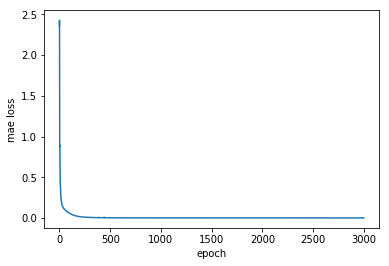

In [172]:
plt.plot(history.epoch, history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('mae loss')
plt.show()

In [173]:
locations = list(df['location'])
# Append the mean prices for the visualization
price_means = df.groupby(df['location'])['price'].mean()
for i in range(len(locations)):
    locations[i] = f"{locations[i]} ({price_means[locations[i]]})"
locations = np.unique(locations)
encoder = LabelEncoder()
encoder.fit(locations)

LabelEncoder()

In [185]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 mined_features_input
1 dense_19
2 location_input
3 batch_normalization_37
4 location_embedding
5 re_lu_19
6 flatten_19
7 concatenate_19
8 batch_normalization_38
9 output


In [194]:
locations = np.unique(locations)
locations.shape

(346,)

In [195]:
embedding_layer = model.layers[4]

get_embedding_output = K.function([embedding_layer.input],
                                  [embedding_layer.output])
embeddings = get_embedding_output([encoder.transform(locations)])[0]

In [196]:
embeddings = np.unique(embeddings, axis=0)
embeddings.shape

(346, 50)

In [197]:
tsne = TSNE()
projected_embeddings = tsne.fit_transform(embeddings)

In [198]:
embeddings_data = pd.DataFrame.from_records(
    list(zip(projected_embeddings[:,0], projected_embeddings[:,1], locations))
)
embeddings_data.columns = ['x', 'y', 'name']

embeddings_data = embeddings_data.drop_duplicates()
embeddings_data.shape

(346, 3)

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fb836b3b160>>
Traceback (most recent call last):
  File "/home/rbotarleanu/.conda/envs/python36/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1415, in __del__
    self._session._session, self._handle, status)
  File "/home/rbotarleanu/.conda/envs/python36/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 526, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.InvalidArgumentError: No such callable handle: 94305824248224


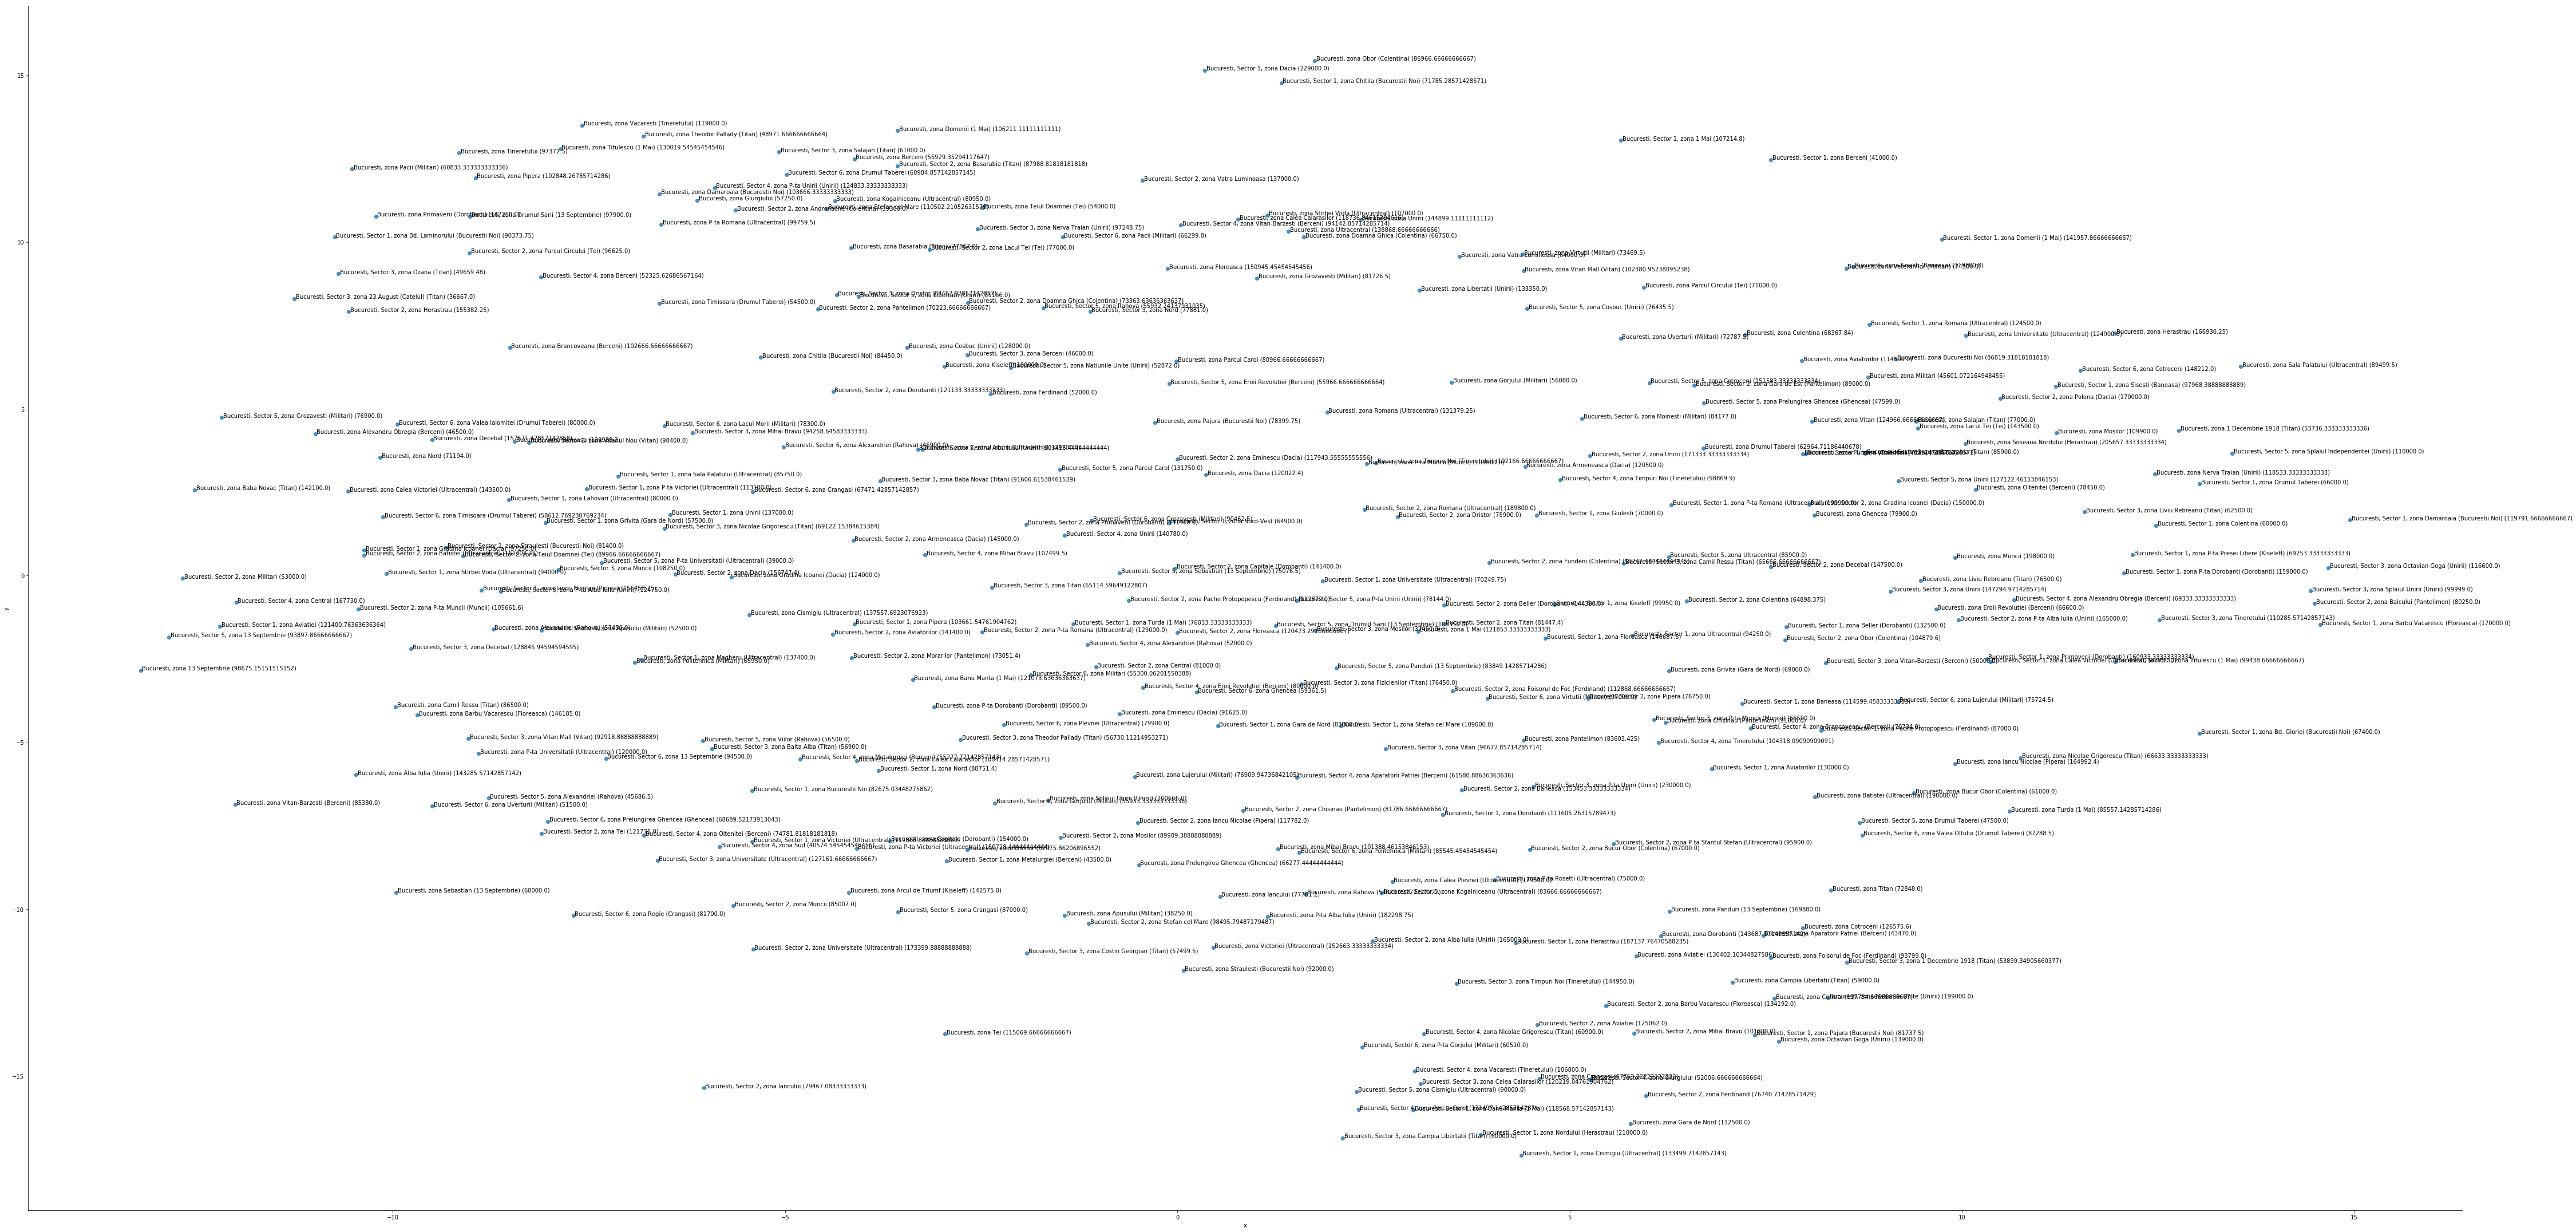

In [199]:
sns.lmplot('x', 'y', data=embeddings_data, fit_reg=False, height=30, aspect=2)

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'name': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'] + 0.01, str(point['name']))

label_point(embeddings_data.x, embeddings_data.y, embeddings_data.name, plt.gca())
plt.savefig('location_embeddings.png')

# Train the model with cross-validation as before

In [154]:
def make_model(input_shape):
    # Inputs are the raw features and the location
    mined_features = Input(shape=input_shape, name='mined_features_input')
    location = Input(shape=(1,), name='location_input')

    # Embedding of location
    embedded_location = Embedding(input_dim=len(encoder.classes_),
                                  output_dim=embedding_size,
                                  name='location_embedding')(location)
    embedded_location = Flatten()(embedded_location)

    # Run the raw features through a FC layer to get an intermediate representation
#     latent_mined_features = Dropout(.2)(mined_features)
    latent_mined_features = mined_features
    latent_mined_features = Dense(64)(latent_mined_features)
    latent_mined_features = BatchNormalization()(latent_mined_features)
    latent_mined_features = ReLU()(latent_mined_features)

    # Concatenate the inputs and perform a linear combination on a single neuron with linear activation
    # this is, essentially, a linear regression
    x = concatenate([latent_mined_features, embedded_location])
    x = BatchNormalization()(x)  # normalize again to homogenize the features
    # x = Dropout(.2)(x)
    out = Dense(1, name='output', activation='linear')(x)
    model = Model(inputs=[mined_features, location], outputs=out)
    model.compile(optimizer=Adam(lr=0.01), loss='mean_squared_error', metrics=[rmse])
    
    return model

In [155]:
# Build and evaluate a model using 5-fold CV
X = np.array(df[independent_variables])
y = np.array(df['price'])

scores = []

# Some look-ahead bias to spice things up
locations = list(df['location'])
encoder = LabelEncoder()
encoder.fit(locations)

kfold = KFold(n_splits=5)

for split, (train_indices, test_indices) in enumerate(kfold.split(range(X.shape[0]))):
    train_X, train_y = X[train_indices], y[train_indices]
    test_X, test_y = X[test_indices], y[test_indices]

    mean_y, std_y = np.mean(train_y), np.std(train_y)
    train_y = (train_y - mean_y) / std_y
    test_y = (test_y - mean_y) / std_y
    
    # Add text mined data
    vectorizer = TfidfVectorizer(min_df=.2, max_df=0.8)
    train_text_data = vectorizer.fit_transform(df['description'].reindex(train_indices))
    test_text_data = vectorizer.transform(df['description'].reindex(test_indices))

    train_X = np.hstack([train_X, train_text_data.todense()])
    test_X = np.hstack([test_X, test_text_data.todense()])

    # Scale the features using z-score scaling (subtract the mean, divide by std)
    scaler = StandardScaler()
    train_X = scaler.fit_transform(train_X)
    test_X = scaler.transform(test_X)

    # Add the locations
    train_locations = encoder.transform(df['location'].reindex(train_indices))
    test_locations = encoder.transform(df['location'].reindex(test_indices))

    # Train the model
    model = make_model(train_X.shape[1:])
    history = model.fit(
        [train_X, train_locations], train_y, epochs=3000,
        validation_data=([test_X, test_locations], test_y),
        callbacks=[scheduler, EarlyStopping(patience=100, monitor='val_rmse'),
                   ModelCheckpoint(f'models/embedding_{split}.h5', monitor='val_rmse')],
        batch_size=train_X.shape[0], # since there are so few data points we can do batch gradient descent
        verbose=False
    )
    model.load_weights(f'models/embedding_{split}.h5')
    y_pred = model.predict([test_X, test_locations])
    score = np.sqrt(mean_squared_error(test_y * std_y + mean_y,
                                       y_pred * std_y + mean_y))  # RMSE
    print('[Split %d] Score: %f' % (split, score))
    print(f"Best training RMSE: {np.min(history.history['rmse'])}")
    scores.append(score)

[Split 0] Score: 20712.672340
Best training RMSE: 5141.986328125
[Split 1] Score: 22651.470298
Best training RMSE: 3588.10107421875
[Split 2] Score: 22599.143997
Best training RMSE: 5599.99169921875
[Split 3] Score: 26894.257111
Best training RMSE: 4765.8095703125
[Split 4] Score: 25886.165212
Best training RMSE: 6081.1142578125


In [156]:
pd.Series(scores).describe()

count        5.000000
mean     23748.741792
std       2559.596796
min      20712.672340
25%      22599.143997
50%      22651.470298
75%      25886.165212
max      26894.257111
dtype: float64

# Try to train just the embeddings

In [236]:
locations = list(df['location'])
# Append the mean prices for the visualization
price_means = df.groupby(df['location'])['price'].mean()
for i in range(len(locations)):
    locations[i] = f"{locations[i]} ({price_means[locations[i]]})"
encoder = LabelEncoder()
encoder.fit(locations)

LabelEncoder()

In [237]:
y = df['price'].ravel()

In [238]:
location = Input(shape=(1,), name='location_input')
embedded_location = Embedding(input_dim=len(encoder.classes_),
                              output_dim=embedding_size,
                              name='location_embedding')(location)
out = Dense(1, name='output')(Flatten()(embedded_location))
model = Model(inputs=location, outputs=out)
model.compile(optimizer=Adam(lr=0.01), loss='mean_squared_error', metrics=[rmse])

In [239]:
def schedule(epoch, lr):
    if epoch in [750, 1500]:
        return lr / 3.0
    return lr
scheduler = LearningRateScheduler(schedule=schedule)

In [240]:
history = model.fit(encoder.transform(locations), (y - np.mean(y)) / np.std(y), epochs=600,
                    batch_size=len(locations))

Epoch 1/600
3656/3656 [==============================] - 2s 428us/step - loss: 1.0068 - rmse: 45074.0742
Epoch 2/600
3656/3656 [==============================] - 0s 2us/step - loss: 0.9143 - rmse: 42954.3555
Epoch 3/600
3656/3656 [==============================] - 0s 3us/step - loss: 0.8292 - rmse: 40904.9961
Epoch 4/600
3656/3656 [==============================] - 0s 3us/step - loss: 0.7489 - rmse: 38875.3008
Epoch 5/600
3656/3656 [==============================] - 0s 2us/step - loss: 0.6752 - rmse: 36911.3477
Epoch 6/600
3656/3656 [==============================] - 0s 2us/step - loss: 0.6106 - rmse: 35102.0703
Epoch 7/600
3656/3656 [==============================] - 0s 3us/step - loss: 0.5579 - rmse: 33552.1328
Epoch 8/600
3656/3656 [==============================] - 0s 2us/step - loss: 0.5190 - rmse: 32361.1465
Epoch 9/600
3656/3656 [==============================] - 0s 2us/step - loss: 0.4948 - rmse: 31599.4688
Epoch 10/600
3656/3656 [==============================] - 0s 2us/step -

Epoch 80/600
3656/3656 [==============================] - 0s 2us/step - loss: 0.4321 - rmse: 29528.2578
Epoch 81/600
3656/3656 [==============================] - 0s 3us/step - loss: 0.4321 - rmse: 29528.0742
Epoch 82/600
3656/3656 [==============================] - 0s 3us/step - loss: 0.4321 - rmse: 29527.8965
Epoch 83/600
3656/3656 [==============================] - 0s 3us/step - loss: 0.4321 - rmse: 29527.7520
Epoch 84/600
3656/3656 [==============================] - 0s 2us/step - loss: 0.4321 - rmse: 29527.6406
Epoch 85/600
3656/3656 [==============================] - 0s 2us/step - loss: 0.4321 - rmse: 29527.5566
Epoch 86/600
3656/3656 [==============================] - 0s 2us/step - loss: 0.4321 - rmse: 29527.4883
Epoch 87/600
3656/3656 [==============================] - 0s 2us/step - loss: 0.4321 - rmse: 29527.4258
Epoch 88/600
3656/3656 [==============================] - 0s 2us/step - loss: 0.4321 - rmse: 29527.3652
Epoch 89/600
3656/3656 [==============================] - 0s 2us

Epoch 159/600
3656/3656 [==============================] - 0s 2us/step - loss: 0.4320 - rmse: 29526.6992
Epoch 160/600
3656/3656 [==============================] - 0s 6us/step - loss: 0.4320 - rmse: 29526.7012
Epoch 161/600
3656/3656 [==============================] - 0s 3us/step - loss: 0.4320 - rmse: 29526.7012
Epoch 162/600
3656/3656 [==============================] - 0s 2us/step - loss: 0.4320 - rmse: 29526.6992
Epoch 163/600
3656/3656 [==============================] - 0s 3us/step - loss: 0.4320 - rmse: 29526.6992
Epoch 164/600
3656/3656 [==============================] - 0s 3us/step - loss: 0.4320 - rmse: 29526.6992
Epoch 165/600
3656/3656 [==============================] - 0s 3us/step - loss: 0.4320 - rmse: 29526.6992
Epoch 166/600
3656/3656 [==============================] - 0s 3us/step - loss: 0.4320 - rmse: 29526.6992
Epoch 167/600
3656/3656 [==============================] - 0s 6us/step - loss: 0.4320 - rmse: 29526.7012
Epoch 168/600
3656/3656 [==============================

3656/3656 [==============================] - 0s 3us/step - loss: 0.4320 - rmse: 29526.6992
Epoch 238/600
3656/3656 [==============================] - 0s 3us/step - loss: 0.4320 - rmse: 29526.7012
Epoch 239/600
3656/3656 [==============================] - 0s 2us/step - loss: 0.4320 - rmse: 29526.6992
Epoch 240/600
3656/3656 [==============================] - 0s 3us/step - loss: 0.4320 - rmse: 29526.6992
Epoch 241/600
3656/3656 [==============================] - 0s 2us/step - loss: 0.4320 - rmse: 29526.7012
Epoch 242/600
3656/3656 [==============================] - 0s 2us/step - loss: 0.4320 - rmse: 29526.7012
Epoch 243/600
3656/3656 [==============================] - 0s 3us/step - loss: 0.4320 - rmse: 29526.6992
Epoch 244/600
3656/3656 [==============================] - 0s 3us/step - loss: 0.4320 - rmse: 29526.7012
Epoch 245/600
3656/3656 [==============================] - 0s 3us/step - loss: 0.4320 - rmse: 29526.7012
Epoch 246/600
3656/3656 [==============================] - 0s 2us/ste

Epoch 316/600
3656/3656 [==============================] - 0s 2us/step - loss: 0.4320 - rmse: 29526.6973
Epoch 317/600
3656/3656 [==============================] - 0s 3us/step - loss: 0.4320 - rmse: 29526.7031
Epoch 318/600
3656/3656 [==============================] - 0s 2us/step - loss: 0.4320 - rmse: 29526.6992
Epoch 319/600
3656/3656 [==============================] - 0s 2us/step - loss: 0.4320 - rmse: 29526.7012
Epoch 320/600
3656/3656 [==============================] - 0s 2us/step - loss: 0.4320 - rmse: 29526.6992
Epoch 321/600
3656/3656 [==============================] - 0s 2us/step - loss: 0.4320 - rmse: 29526.6992
Epoch 322/600
3656/3656 [==============================] - 0s 2us/step - loss: 0.4320 - rmse: 29526.7012
Epoch 323/600
3656/3656 [==============================] - 0s 3us/step - loss: 0.4320 - rmse: 29526.7012
Epoch 324/600
3656/3656 [==============================] - 0s 2us/step - loss: 0.4320 - rmse: 29526.7012
Epoch 325/600
3656/3656 [==============================

3656/3656 [==============================] - 0s 3us/step - loss: 0.4320 - rmse: 29526.7012
Epoch 395/600
3656/3656 [==============================] - 0s 2us/step - loss: 0.4320 - rmse: 29526.7012
Epoch 396/600
3656/3656 [==============================] - 0s 3us/step - loss: 0.4320 - rmse: 29526.7012
Epoch 397/600
3656/3656 [==============================] - 0s 2us/step - loss: 0.4320 - rmse: 29526.6992
Epoch 398/600
3656/3656 [==============================] - 0s 2us/step - loss: 0.4320 - rmse: 29526.6992
Epoch 399/600
3656/3656 [==============================] - 0s 3us/step - loss: 0.4320 - rmse: 29526.7012
Epoch 400/600
3656/3656 [==============================] - 0s 9us/step - loss: 0.4320 - rmse: 29526.6992
Epoch 401/600
3656/3656 [==============================] - 0s 2us/step - loss: 0.4320 - rmse: 29526.7012
Epoch 402/600
3656/3656 [==============================] - 0s 2us/step - loss: 0.4320 - rmse: 29526.7012
Epoch 403/600
3656/3656 [==============================] - 0s 3us/ste

Epoch 473/600
3656/3656 [==============================] - 0s 2us/step - loss: 0.4320 - rmse: 29526.7012
Epoch 474/600
3656/3656 [==============================] - 0s 3us/step - loss: 0.4320 - rmse: 29526.7012
Epoch 475/600
3656/3656 [==============================] - 0s 3us/step - loss: 0.4320 - rmse: 29526.7012
Epoch 476/600
3656/3656 [==============================] - 0s 3us/step - loss: 0.4320 - rmse: 29526.6992
Epoch 477/600
3656/3656 [==============================] - 0s 2us/step - loss: 0.4320 - rmse: 29526.7012
Epoch 478/600
3656/3656 [==============================] - 0s 2us/step - loss: 0.4320 - rmse: 29526.7012
Epoch 479/600
3656/3656 [==============================] - 0s 3us/step - loss: 0.4320 - rmse: 29526.7012
Epoch 480/600
3656/3656 [==============================] - 0s 3us/step - loss: 0.4320 - rmse: 29526.7012
Epoch 481/600
3656/3656 [==============================] - 0s 3us/step - loss: 0.4320 - rmse: 29526.7012
Epoch 482/600
3656/3656 [==============================

3656/3656 [==============================] - 0s 2us/step - loss: 0.4320 - rmse: 29526.7012
Epoch 552/600
3656/3656 [==============================] - 0s 2us/step - loss: 0.4320 - rmse: 29526.7012
Epoch 553/600
3656/3656 [==============================] - 0s 2us/step - loss: 0.4320 - rmse: 29526.7012
Epoch 554/600
3656/3656 [==============================] - 0s 3us/step - loss: 0.4320 - rmse: 29526.6992
Epoch 555/600
3656/3656 [==============================] - 0s 2us/step - loss: 0.4320 - rmse: 29526.7012
Epoch 556/600
3656/3656 [==============================] - 0s 2us/step - loss: 0.4320 - rmse: 29526.7012
Epoch 557/600
3656/3656 [==============================] - 0s 3us/step - loss: 0.4320 - rmse: 29526.6992
Epoch 558/600
3656/3656 [==============================] - 0s 2us/step - loss: 0.4320 - rmse: 29526.7012
Epoch 559/600
3656/3656 [==============================] - 0s 2us/step - loss: 0.4320 - rmse: 29526.7012
Epoch 560/600
3656/3656 [==============================] - 0s 2us/ste

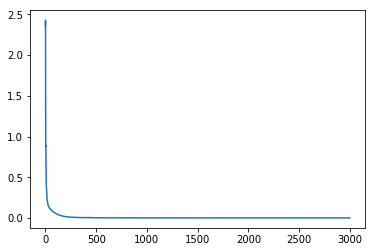

In [221]:
plt.plot(history.epoch, history.history['loss'])
plt.show()

In [226]:
locations = encoder.transform(np.unique(locations))

In [227]:
get_embedding_output = K.function([model.layers[1].input],
                                  [model.layers[1].output])
embeddings = get_embedding_output([locations])[0]

In [228]:
embeddings = np.unique(embeddings, axis=0)
embeddings.shape

(346, 50)

In [229]:
tsne = TSNE()
projected_embeddings = tsne.fit_transform(embeddings)

In [231]:
embeddings_data = pd.DataFrame.from_records(
    list(zip(projected_embeddings[:,0], projected_embeddings[:,1], encoder.inverse_transform(locations)))
)
embeddings_data.columns = ['x', 'y', 'name']

embeddings_data = embeddings_data.drop_duplicates()
embeddings_data.shape

(346, 3)

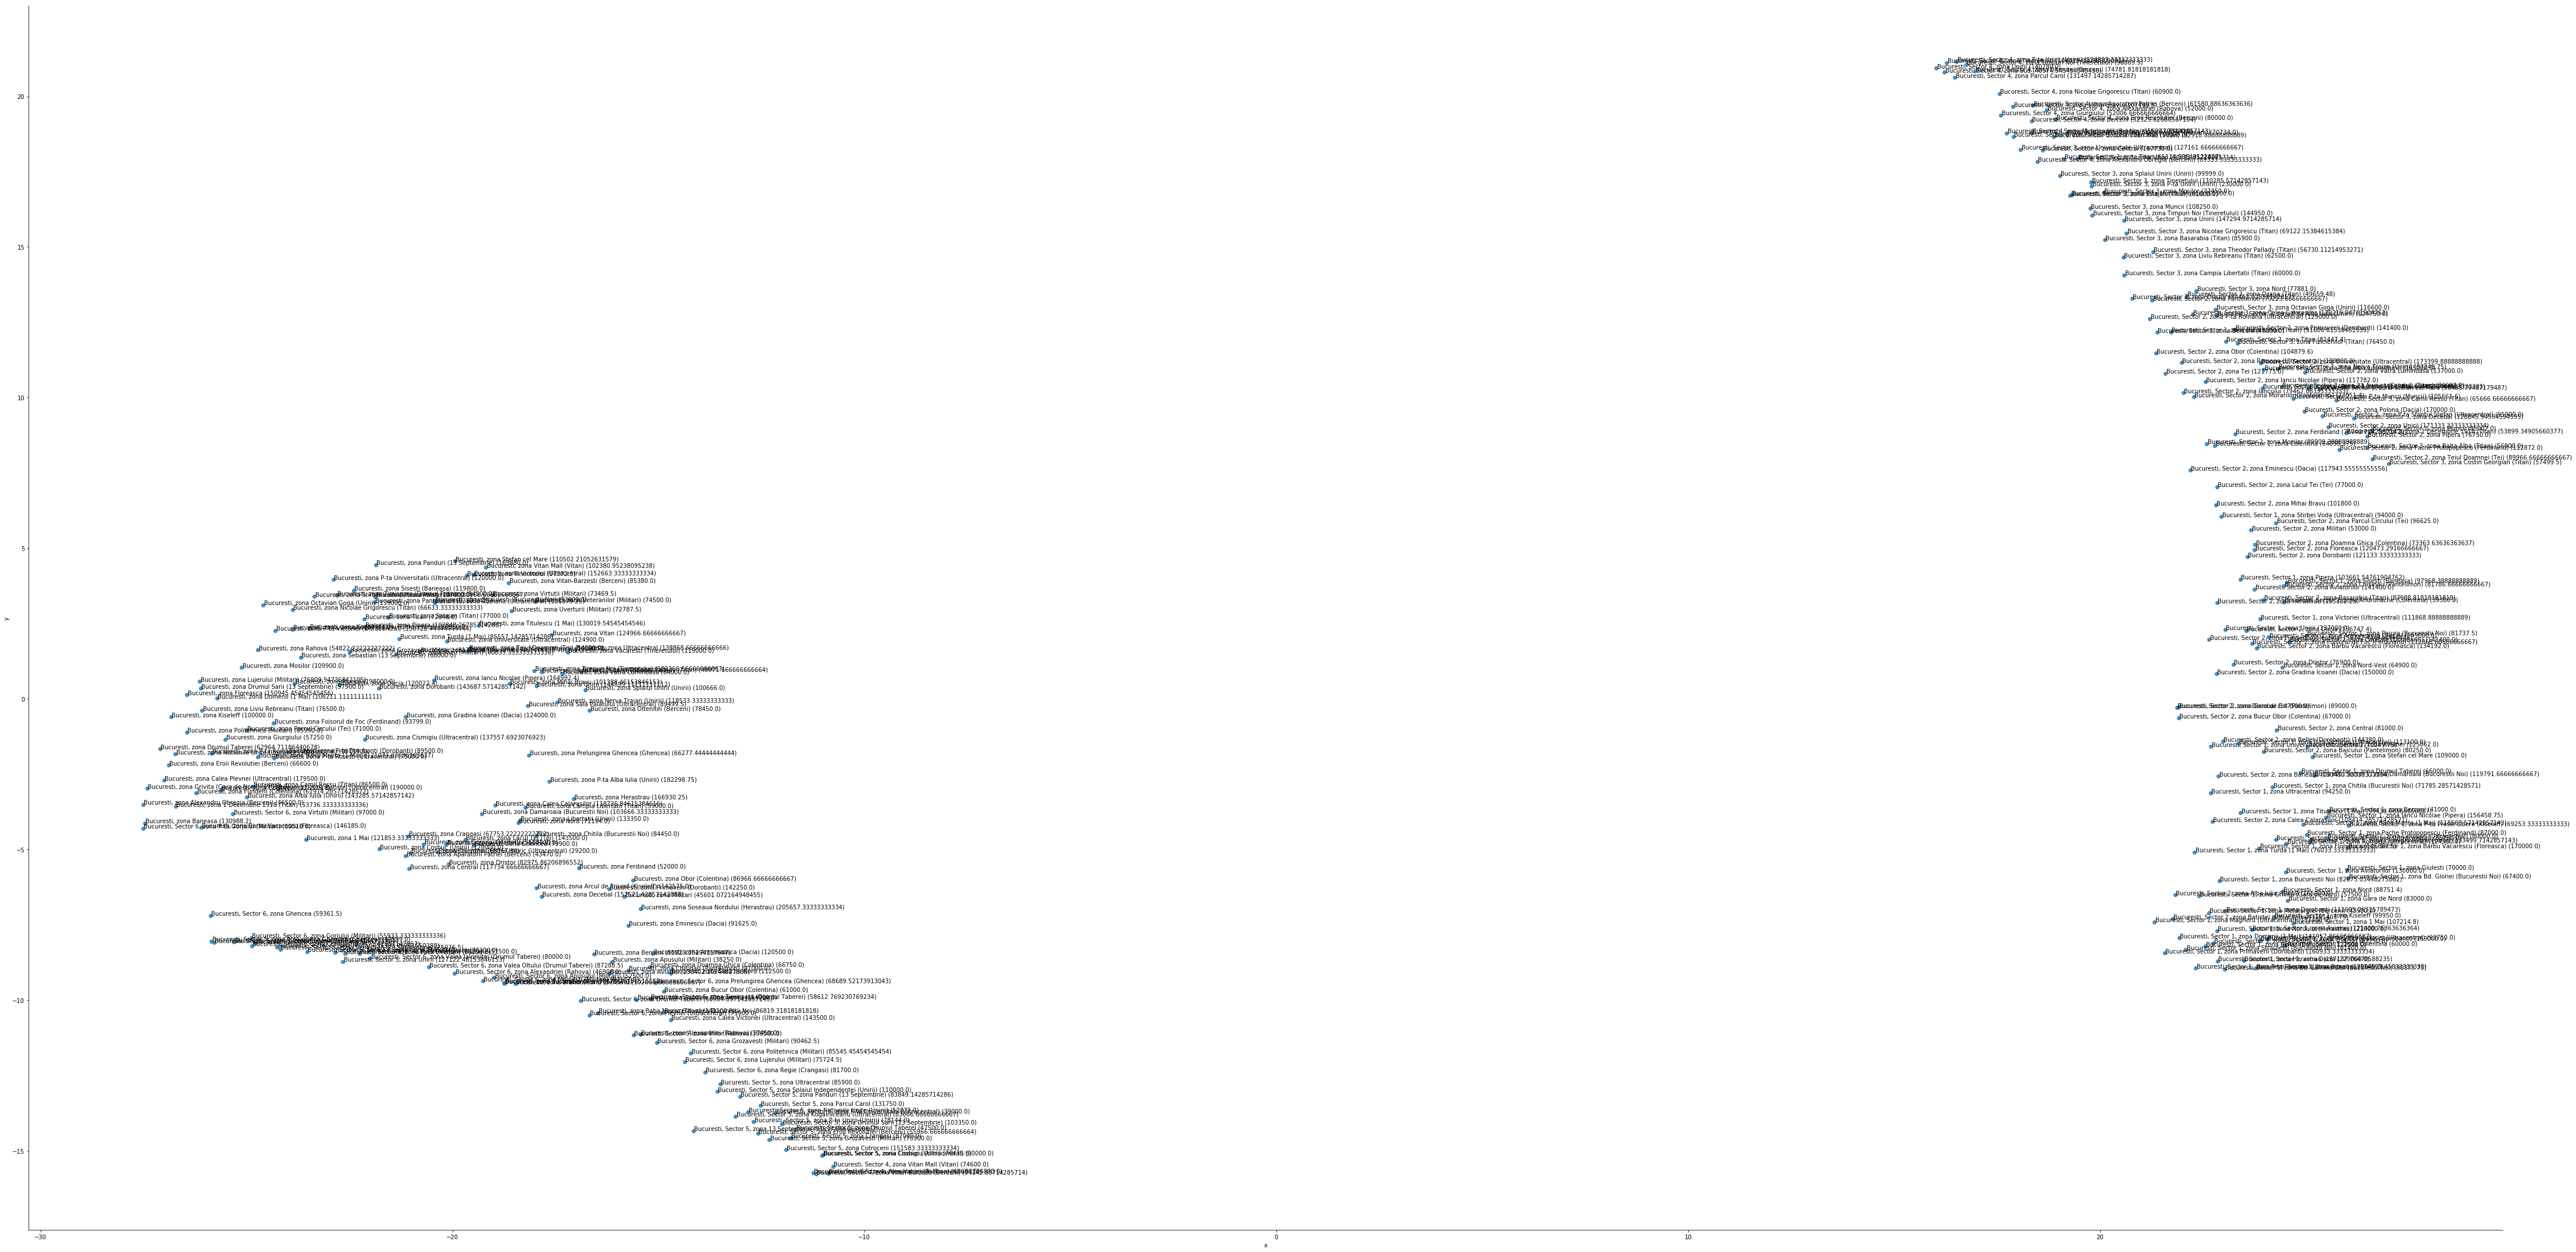

In [232]:
sns.lmplot('x', 'y', data=embeddings_data, fit_reg=False, height=30, aspect=2)

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'name': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'] + 0.01, str(point['name']))

label_point(embeddings_data.x, embeddings_data.y, embeddings_data.name, plt.gca())
plt.savefig('location_embeddings_only.png')